# 3k2f 60 C High Pressure

### Scaling Time

We scale time in this version of the analysis by a multiplicative factor to ensure that the time between the start time (estimated to be 10:00am 7/15/19) and the measurement time (time-stamped on the images) is equal to the final time listed on the axis of the Belsorp plot. I've estimated this factor to be around 16/15, but I will compute it precisely in the following analysis. This scaling differs from the previous approach by scaling time by a multiplicative factor instead of shifting it.

### Hysteresis in Drop Volume

For some reason, the drop volume shows hysteresis, having a higher value during the desorption stage at the end than the adsorption stage at the beginning. My hypothesis is that the drop did not properly reach equilibrium during at least one of the stages, resulting in a lag in the drop volume behind the pressure that would be consistent with the observation of hysteresis. Nevertheless, the weight of CO2 dissolved in the polyol follows a similar hysteresis, as evidenced by the agreement of specific volume between the adsorption and desorption measurements when using the raw, hysteretic drop volume data, and seeing a discrepancy between the adsorption and desorption measurements of the specific volume when using the fit drop volume data.

### Description of Experiment

We are repeating the measurement of the 3k2f PPG polyol at 60 C to extend our data set to higher pressure in search of interesting supercritical behaviors. Along the way we will repeat a few data points at lower pressures to assess the repeatability of measurements. The experiment was performed with manual pressure changes and used DataThief on the plot generated by the Belsorp BG software to extra gravimetry data. 

The polyol is difunctional with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from July 15-24, 2019.
    
The analysis computes the **solubility, interfacial tension, and specific volume** of the sample at pressures from 0 to 80 bar at 60 C. No diffusivity data are provided because of the lack of reliable time-series data at either the beginning or the end of the sorption curve due to large fluctuations in temperature (which have a magnified effect at higher pressure).

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [5]:
%load_ext autoreload
%autoreload 2

# imports 3rd party libraries
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import glob
import os
from scipy.interpolate import interp1d

# imports custom libraries
import sys
sys.path.append('../src/')
import dataproc
from timedate import TimeDate

file_template = '201907*_*_*kPa*'
metadata_file = '20190715_0724_3k2f_60c_hip_metadata.txt'
# folder for gravimetry data from DataThief analysis of Belsorp BG data plotted from Rubotherm
datathief_folder = '../input/datathief/20190715_0724_3k2f_60c_hip/'
grav_folder = '../input/gravimetry/'
# reference time is time when Belsorp started recording data
date_ref = '7/15/2019'
time_ref = '10:00:00'
# system parameters
polyol = '3k2f_hip'
T = 60
i_50kPa = 0

p_filepath_template = os.path.join(datathief_folder + file_template + '_p.txt')
p_file_list = glob.glob(p_filepath_template)
T_filepath_template = os.path.join(datathief_folder + file_template + '_T.txt')
T_file_list = glob.glob(T_filepath_template)
mp1_filepath_template = os.path.join(datathief_folder + file_template + '_mp1.txt')
mp1_file_list = glob.glob(mp1_filepath_template)

# initialize numpy arrays to store measured values (time,pressure, temperature, and MP1 balance reading)
t_grav = []
p_list = []
T_list = []
br_list = []
bp_list = []
time_list = []
date_list = []
# load metadata
metadata = pd.read_csv(datathief_folder + metadata_file, header=0)

# create reference date and time object
time_date_ref = TimeDate(date_str=date_ref, time_str=time_ref)
# load data from each file
for i in range(len(p_file_list)):
    # extract filepaths for pressure, temperature, and MP1 balance reading
    p_file = p_file_list[i]
    T_file = T_file_list[i]
    mp1_file = mp1_file_list[i]
    # load data
    t_p, p = dataproc.load_datathief_data(p_file)
    t_T, T_ = dataproc.load_datathief_data(T_file)
    t_mp1, mp1 = dataproc.load_datathief_data(mp1_file)
    # remove repeats and interpolate values so spacing is even
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2)
       
    # identify pressure step as a reference point in time to synchronize different runs
    t_mult = dataproc.compute_t_multiplier(metadata, i, t_p_interp, date_ref, time_ref)
        
    # synchronize times of all measurements using only times that overlap
    t_min = np.max([np.min(t_p), np.min(t_T), np.min(t_mp1)])
    t_max = np.min([np.max(t_p), np.max(t_T), np.max(t_mp1)])
    # remove repeats and interpolate values so spacing is even (all interpolated times should be the same)
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2, t_min=t_min, t_max=t_max)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2, t_min=t_min, t_max=t_max)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2, t_min=t_min, t_max=t_max)
    
    t_mult = 1.052
    # scale time
    t_p_interp *= t_mult
    
    # concatenate data
    zero_last = i != i_50kPa # accidentally took zero measurement first for 50 kPa
    dataproc.concatenate_data(metadata, i, date_ref, time_ref, time_list, date_list, 
                     t_grav, t_p_interp, p_interp, p_list, T_interp, T_list, 
                     mp1_interp, br_list, bp_list, zero_last=zero_last)
    
# save results in TRD file format
df_trd = pd.DataFrame(columns=['DATE', 'TIME', 'Julabo_Ext_PV', 'WEITGHT(g)', 'BALANCE POSITION', 'Now Pressure(kPa)'])
df_trd['DATE'] = date_list
df_trd['TIME'] = time_list
df_trd['Julabo_Ext_PV'] = T_list
df_trd['WEITGHT(g)'] = br_list
df_trd['BALANCE POSITION'] = bp_list
df_trd['Now Pressure(kPa)'] = p_list
trd_save_hdr = grav_folder + '%s_%dc-TRD-071519-1000' % (polyol, T) # 1000 indicates the reference time 10:00

# save csv file with TRD header
dataproc.save_trd(df_trd, trd_save_hdr)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Having created an artificial TRD file in the format that would have been produced by the Belsorp program during an automatic test, we can now proceed through the analysis as usual.

In [6]:
import errprop
import plot

# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../input/adsa/20190715_0724_3k2f_hip/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190716_0717_3k2f_60c_hip_adsa_volume.csv', '20190718_0719_3k2f_60c_hip_adsa_volume.csv',
                        '20190719_3k2f_60c_hip_adsa_volume.csv', '20190719_0720_3k2f_60c_hip_adsa_volume.csv',
                        '20190722_3k2f_60c_hip_adsa_volume.csv', '20190722_0723_3k2f_60c_hip_adsa_volume.csv',
                        '20190723_0724_3k2f_60c_hip_adsa_volume.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = ['20190716_0717_3k2f_60c_hip_adsa_if_tension.csv', '20190718_0719_3k2f_60c_hip_adsa_if_tension.csv',
                            '20190719_3k2f_60c_hip_adsa_if_tension.csv', '20190719_0720_3k2f_60c_hip_adsa_if_tension.csv',
                            '20190722_3k2f_60c_hip_adsa_if_tension.csv', '20190722_0723_3k2f_60c_hip_adsa_if_tension.csv',
                            '20190723_0724_3k2f_60c_hip_adsa_if_tension.csv']
# filepath to gravimetry data 
grav_filepath = trd_save_hdr + '.csv'
# file path to save results
save_folder = '../output/'
save_data_name = '3k2f_60c_hip.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 7/15 13:04; adsa videos: 14:27, 7/16; 19:18, 7/17; 14:14, 7/18; 9:16, 7/19; 16:48, 7/19
# adsa_time_list = ['14:27:00', '19:18:00', '14:14:00', '9:16:00', '16:48:00', '10:02:00', '18:15:00', '16:02:00', '15:35:00']
# adsa_date_list = ['7/16/2019', '7/17/2019', '7/18/2019', '7/19/2019', '7/19/2019', '7/22/2019', '7/22/2019', 
#                   '7/23/2019', '7/24/2019']
adsa_time_list = ['14:27:00', '14:14:00', '9:16:00', '16:48:00', '10:02:00', '18:15:00', '16:02:00']
adsa_date_list = ['7/16/2019', '7/18/2019', '7/19/2019', '7/19/2019', '7/22/2019', '7/22/2019', 
                  '7/23/2019']
# number of minutes of measurements to average for surface tension and volume readings
n_minutes = 120
# number of measurements to average (if the method using minutes doesn't work)
n_adsa = 20

# polyol code name
polyol = '3k2f_hip'
# weight of sample in atmospheric pressure, measured with analytical balance on 7/5/19 [g]
w_samp_atm = 1.1153
# volume of drop in atmospheric pressure, from 20190716_3k2f_60c_atm_snapshot.mdb [uL]
v_drop_atm = 4.136
# uncertainty in drop volume at atmospheric pressure [uL]
s_v_drop_atm = 0.05
# volume of drop under vacuum, from 20190716_3k2f_60c_0bar_snapshot.mdb [uL]
v_drop_0 = 4.116
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS)
# and extrapolated using P-1000 Dow data [g/mL]
rho_samp_atm = 0.977
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]
# measurements made manually with Rubotherm on 7/16/19 at 60 C
mp1_atm = 14.02994
zero_atm = 5.63404
# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = metadata['p set [kPa]'].to_numpy(dtype=float)
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# resolution of pressure measurement [kPa]
p_resolution = 1
# number of measurements of pressure within equilibrium (2 min per measurement --> 30 minutes, 2-3 cycles of temperature,
# which fluctuated every 10-15 minutes.)
n_p_eq = 50

# CONSTANTS
# Set-point temperature [C]
T = 60
# atmospheric pressure [kPa]
P_ATM = 101.3
# density of air at sea level acc. to https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html [g/mL]
RHO_AIR = 1.225E-3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + RHO_AIR*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

We first compute the time delay from the reference time of the experiment (roughly the beginning) to the beginning of each ADSA measurement.

In [7]:
# initialize list of time delays until the start of the ADSA measurements
adsa_t0_list = []
# use TimeDate class to compute seconds of delay between the times and dates provided
for i in range(len(adsa_time_list)):
    adsa_time = adsa_time_list[i]
    adsa_date = adsa_date_list[i]
    adsa_td = TimeDate(date_str=adsa_date, time_str=adsa_time)
    # compute seconds after reference time that ADSA was started
    adsa_t0_list += [TimeDate.diff_min(time_date_ref, adsa_td)*60]

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [8]:
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, 
                                                                      adsa_t0_list, grav_filepath, p_set_arr, zero_t_grav=False,
                                                                          time_date_ref=time_date_ref)
# convert times from seconds to minutes
t_adsa /= 60
t_grav = t_grav / 60.
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,specific volume [mL/g],specific volume (fit) [mL/g],specific volume error [mL/g],specific volume error (stat) [mL/g],specific volume error (sys) [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (sqrt) std [cm^2/s],diffusivity (exp) [cm^2/s],diffusivity (exp) std [cm^2/s],diffusion time constant [s]
0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot Drop Volume over Time Alongside Pressure

To determine if the gravimetry and ADSA data are accurately synchronized, I will plot the drop volume alongside the pressure. Changes in pressure should be quickly followed by the appropriate change in drop volume.

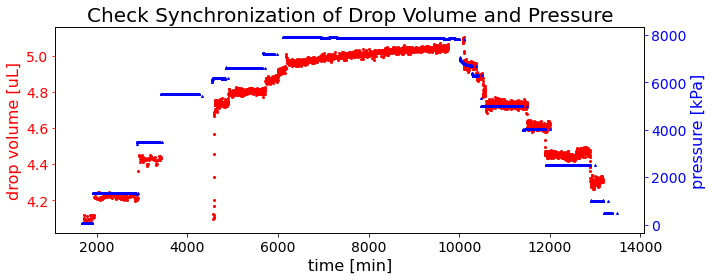

In [9]:
plot.plot_two_axes(t_adsa, v_drop, p_arr, x2=t_grav, figsize=(10,4), labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='Check Synchronization of Drop Volume and Pressure')

They appear to be synchronized.

## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 45 kPa.
Rejected 1 outliers.
Drop volume = 4.097133 uL.
Pressure = 1330 kPa.
Rejected 1 outliers.
Drop volume = 4.226067 uL.
Pressure = 3500 kPa.
Drop volume = 4.422533 uL.
Pressure = 5500 kPa.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.423667 uL.
Pressure = 6200 kPa.
Rejected 1 outliers.
Drop volume = 4.730067 uL.
Pressure = 6600 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.805800 uL.
Pressure = 7200 kPa.
Rejected 1 outliers.
Drop volume = 4.870733 uL.
Pressure = 7850 kPa.
Rejected 1 outliers.
Drop volume = 5.026467 uL.
Pressure = 6700 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.956600 uL.
Pressure = 6300 kPa.
Rejected 1 outliers.
Drop volume = 4.890000 uL.
Pressure = 5000 kPa.
Rejected 1 outliers.
Drop volume = 4.728800 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Drop volume = 4.602200 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Drop volume = 4.459800 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.
Drop volume = 4.315467 uL.
Pressure = 500 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.315467 uL.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,specific volume [mL/g],specific volume (fit) [mL/g],specific volume error [mL/g],specific volume error (stat) [mL/g],specific volume error (sys) [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (sqrt) std [cm^2/s],diffusivity (exp) [cm^2/s],diffusivity (exp) std [cm^2/s],diffusion time constant [s]
0,45.0,45.1745,1,5.63332,1e-05,14.0267,0.000154919,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,1333.33,1,5.61248,1e-05,13.9463,0.00462552,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,3496.92,1,5.57332,1e-05,13.8031,0.00814494,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,5493.83,1,5.52911,1e-05,13.6444,0.00778311,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,6156.31,12.5476,5.51185,1e-05,13.5397,0.0192997,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


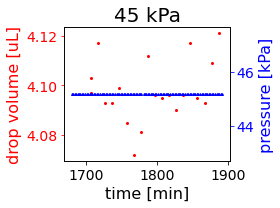

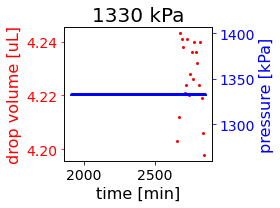

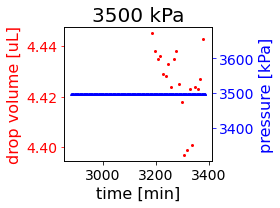

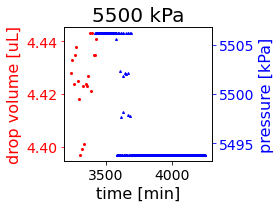

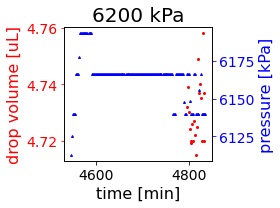

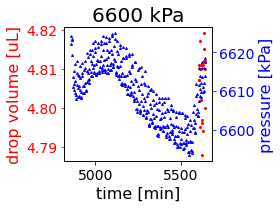

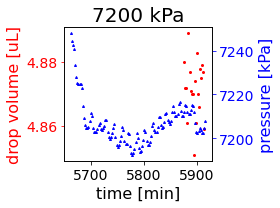

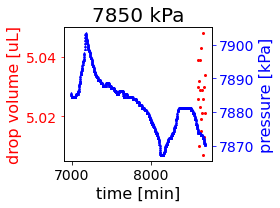

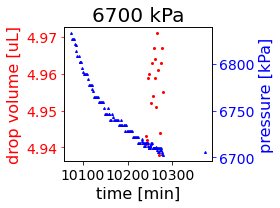

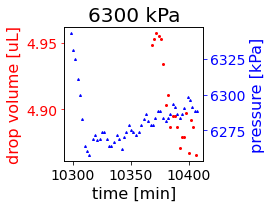

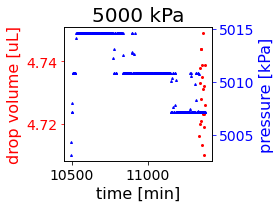

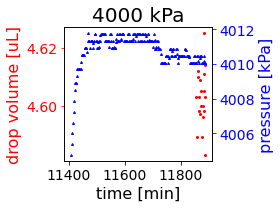

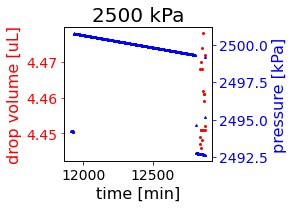

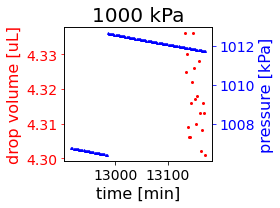

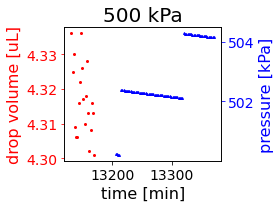

In [10]:
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    if p_set == np.max(p_set_arr):
        window_reduction = 0.01
    else:
        window_reduction = 0.25
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1, window_reduction=window_reduction)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = max(np.std(p_eq), p_resolution)

    # store results in data frame
    # use times to determine indices of ADSA to use
    i_adsa = dataproc.get_inds_adsa(t_adsa, t_grav, i_p0, i_p1, n_adsa)
    plot.plot_two_axes(t_adsa[i_adsa], v_drop[i_adsa], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='%d kPa' % p_set)

    df = dataproc.store_grav_adsa_manual(df, metadata, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_minutes, n_p_eq,
                                        date_ref, time_ref, ref_by_dp=False)

df.head()

There were no ADSA data available at 500 kPa. **I also don't understand why there is hysteresis in the drop volume. Did I adsorb and desorb too quickly that I didn't reach equilibrium?**

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum. Since I did not take a measurement with the balance under vacuum, I will extrapolate the balance reading using measurements made at atmospheric pressure and 50 kPa, assuming a linear change in the balance reading at such low pressures.

In [11]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# balance reading at atmospheric pressure made before starting the tests
br_eq_atm = mp1_atm - zero_atm
# (extract value at 50 kPa) [g]
br_eq_50kPa = br_eq[i_50kPa]
# extrapolate balance reading at 0 kPa assuming Henry's Law [g]
# also assumes that balance reading in atmosphere (air) would not be substantially different
# if it were in CO2 because of the small amount of dissolved gas in the polyol at p = p_atm
p_50kPa = df['p actual [kPa]'].iloc[i_50kPa]
br_eq_0 = br_eq_50kPa - p_50kPa*(br_eq_atm - br_eq_50kPa)/(P_ATM - p_50kPa)

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere by subtracting extrapolated balance reading at 0 kPa
w_gas_atm = (br_eq_atm - br_eq_0) + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 1.105282 g vs. mass of polymer at atmospheric pressure = 1.115300 g.
Dry polymer mass estimated using tare measurement = 1.110110225754644 g.
Volume of dry polymer in crucible is approximately ~ 1.136036 mL (using atmospheric density).


### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [12]:
# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_atm*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = s_v_drop_atm*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # uncertainty in weight measured by Rubotherm = resolution of Rubotherm [g]

### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

However, the drop volume data seemed to have gotten corrupted or miscaled and no longer agree with the results I had from August. Thankfully, I saved those results in the dataframe below, which I load below.

In [14]:
df_3k2f_60c = pd.read_csv(os.path.join(save_folder, '3k2f_60c_aug.csv'))
df['drop volume [uL]'] = np.concatenate((df_3k2f_60c['drop volume [uL]'].iloc[17:31].to_numpy(dtype=float),np.array([np.nan])))

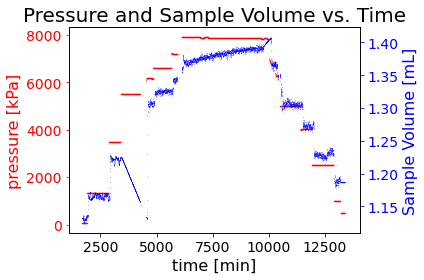

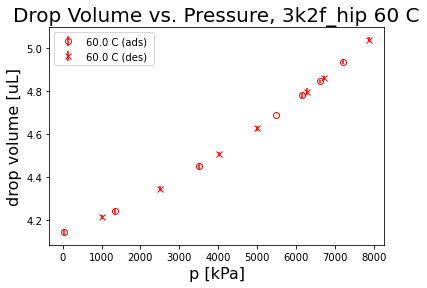

In [15]:
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
s_v_drop_eq = df['drop volume std [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp
# error in volume of sample [mL]
s_v_samp = errprop.error_v_samp(v_samp, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, 
                                 s_v_drop_eq, v_drop_ref, s_v_drop_ref)
df['sample volume std [mL]'] = s_v_samp

# compute live change in volume
v_samp_adsa = v_drop / v_drop_atm * v_samp_atm
v_samp_grav = np.interp(t_grav, t_adsa, v_samp_adsa)
inds_pos = t_grav > 0
plot.plot_two_axes(t_grav[inds_pos], p_arr[inds_pos], v_samp_grav[inds_pos], labels=[r'$p$', r'$V_{samp}$'], xlabel='time [min]', 
                   ms=0.1, ylabels=['pressure [kPa]', 'Sample Volume [mL]'], title='Pressure and Sample Volume vs. Time')

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_v_drop_eq, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight') 

#### Fitting Drop Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the drop volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the drop volume, we will reduce the error in the sample volume, and thus in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*

This method greatly reduces the statistical error but it seems to introduce some systematic error (see Specific Volume (Fit) plot further down).

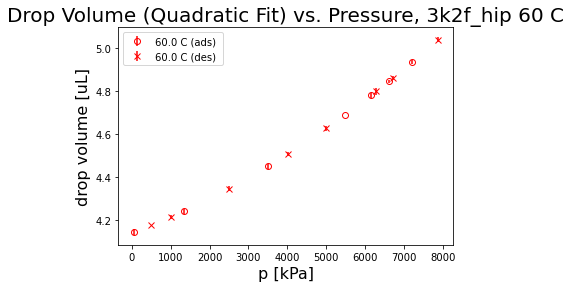

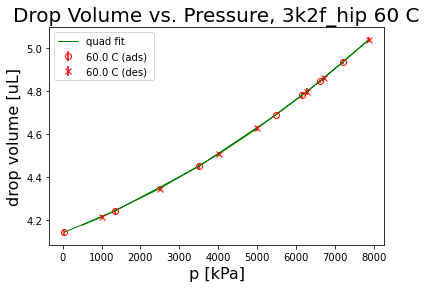

In [16]:
# Compute fitted drop volume and uncertainty [uL]
v_drop_fit, s_v_drop_fit = dataproc.fit_v_drop(p_plot, v_drop_eq, s_v_drop_eq)

# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_fit, s_v_drop_fit, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot equilibrium drop volume vs. p alongside the fit (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_v_drop_eq, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot, v_drop_fit, ax=ax, marker=None, lw=1, color='g', label='quad fit')
plt.legend()

# Use fitted drop volume to estimate the sample volume
v_samp_fit = v_drop_fit / v_drop_atm * v_samp_atm
s_v_samp_fit = errprop.error_v_samp(v_samp_fit, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref,
                                     v_drop_fit, s_v_drop_fit, v_drop_ref, s_v_drop_ref)

# use fit to estimate sample volume due to missing drop volume at low pressures during desorption
df['drop volume (fit) [uL]'] = v_drop_fit
df['drop volume (fit) std [uL]'] = s_v_drop_fit
df['sample volume (fit) [mL]'] = v_samp_fit
df['sample volume (fit) std [mL]'] = s_v_samp_fit

To compare with the previous 3k2f 60 C test, I will plot the percent of swelling of each test below.

FileNotFoundError: [Errno 2] File ..\g-adsa_results\3k2f_60c_lop.csv does not exist: '..\\g-adsa_results\\3k2f_60c_lop.csv'

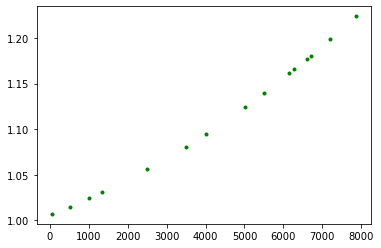

In [17]:
v_swell = v_drop_fit / v_drop_0
ax = plot.plot_line(p_plot, v_swell, lw=0, color='g', label='hi p')

df_prev = pd.read_csv('..\\g-adsa_results\\3k2f_60c_lop.csv')
p_prev = df_prev['p actual [kPa]'].to_numpy(dtype=float)
v_drop_prev = df_prev['drop volume [uL]'].to_numpy(dtype=float)
v_swell_prev = v_drop_prev / v_drop_prev[0]
ax = plot.plot_line(p_prev, v_swell_prev, lw=0, color='b', ax=ax, label='prev', title='Swelling Ratio %s, %d C' % (polyol, T))
plt.legend()

The percent swelling seems to match only for the adsorption stage, whereas the percent swelling during desorption is a few percent higher.

### Correcting for Pressure Fluctuations

At higher pressures, the fluctuations in the temperature of the cell (about 0.1-0.2 C) caused by the cycle of the air conditioning system in the laboratory can cause significant fluctuations in the measuring point 1 (MP1) balance reading. To correct for these fluctuations, I will perform a "live" buoyancy correction at each data point.

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 45 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1330 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3500 kPa.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 5500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 7200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 7850 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6700 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6300 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


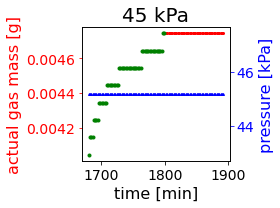

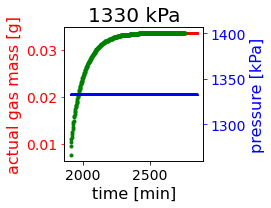

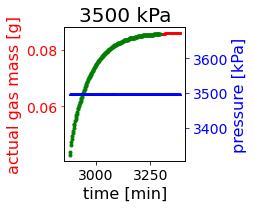

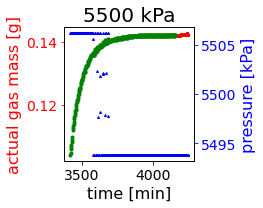

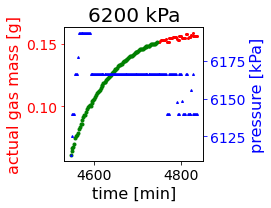

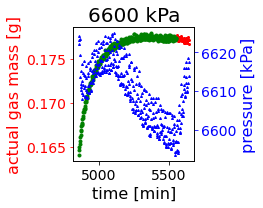

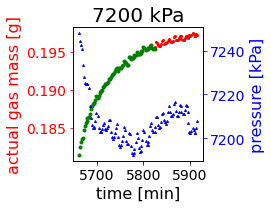

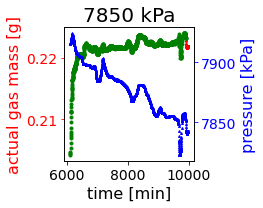

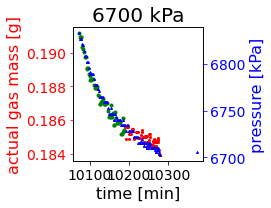

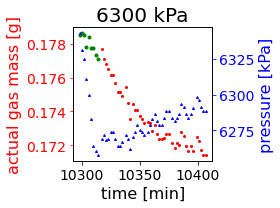

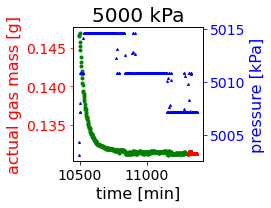

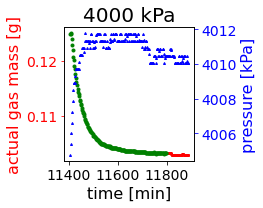

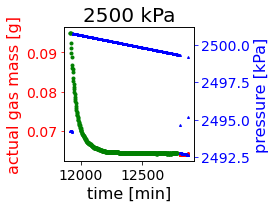

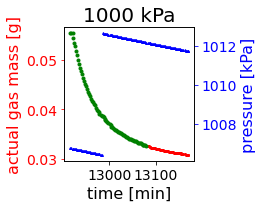

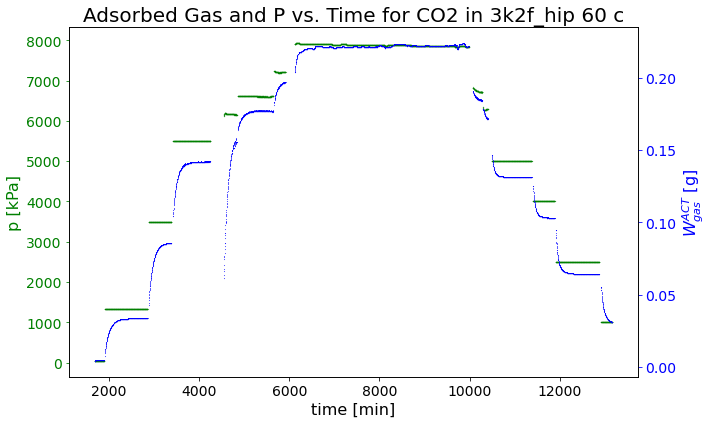

In [18]:
# parameters to insert at beginning
n_minutes = 90
# initalize marker for pressure bounds
last_bound = 0
# initialize arrays to store data
t_mp1_arr = np.array([])
w_gas_act_arr = np.array([])
p_mp1_arr = np.array([])

# set default mass of gas adsorbed in polyol to 0 and uncertainty to that of reference measurement [g]
df['M_0 (prev) [g]'] = np.zeros([len(p_set_arr)])
df['M_0 (prev) [g]'].iloc[0] = w_samp_atm - w_poly # initial mass at 0 pressure is difference of atm mass and dry mass [g]
df['M_0 (prev) std [g]'] = s_w_gas_ref[0]*np.ones([len(p_set_arr)])

# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True, t_eq=n_minutes)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
    
    # Append results
    t_mp1_arr = np.concatenate((t_mp1_arr, t_mp1))
    w_gas_act_arr = np.concatenate((w_gas_act_arr, w_gas_act))
    p_mp1_arr = np.concatenate((p_mp1_arr, p_mp1))
    # get indices to average the last X number of minutes
    inds_eq = dataproc.get_inds_eq(t_mp1, n_minutes)
    inds_trans = np.where(t_mp1[-1] - t_mp1 > n_minutes)[0]
    w_gas_act_eq = df['actual weight of dissolved gas [g]'].iloc[i]
    s_w_gas_act_eq = max(df['actual weight of dissolved gas std [g]'].iloc[i], s_w_gas_ref[0])
    # save new uncertainty
    df['actual weight of dissolved gas std [g]'].iloc[i] = s_w_gas_act_eq
    
    # plot dissolved gas for each pressure on same plot
    ax = plot.plot_two_axes(t_mp1[inds_eq], w_gas_act[inds_eq], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['gas mass', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['actual gas mass [g]', 'pressure [kPa]'], title='%d kPa' % p_set)
    plot.plot_line(t_mp1[inds_trans], w_gas_act[inds_trans], color='g', ax=ax)
    
    # save gas mass from current run for next M_0 and uncertainty
    if i < len(p_set_arr)-1:
        df['M_0 (prev) [g]'].iloc[i+1] = w_gas_act_eq 
        df['M_0 (prev) std [g]'].iloc[i+1] = s_w_gas_act_eq 
    # save gas mass from current run for current M_infty and uncertainty
    df['M_infty (final) [g]'].iloc[i] = w_gas_act_eq 
    df['M_infty (final) std [g]'].iloc[i] = s_w_gas_act_eq 
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_mp1_arr, p_mp1_arr, w_gas_act_arr, markers=['o', '^'], labels=['p', r'$w_{gas}$'], figsize=(10,6),
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=['g', 'b'], ms=0.2,
                       xlabel='time [min]', ylabels=['p [kPa]', r'$W_{gas}^{ACT}$ [g]'])

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

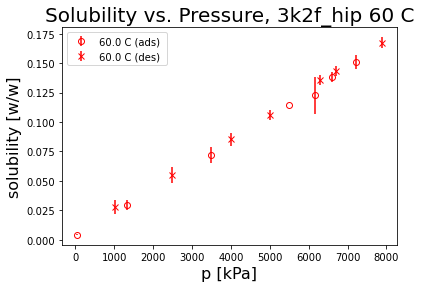

In [19]:
# COMPUTE AND PLOT SOLUBILITY

# load "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_gas_act = df['actual weight of dissolved gas [g]'].to_numpy(dtype=float)
# load buoyancy correction 
buoyancy = df['buoyancy correction [g]'].to_numpy(dtype=float)
# calculate solubility w/w
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, buoyancy, w_gas_act, v_drop_eq, 
                                    s_v_drop_eq,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Previous Data

Since we have already measured the solubility of 3k2f at 60 C for pressures up to almost 5.5 MPa, we can explore the repeatability of these experiments by comparing our previous measurements with the present measurements.

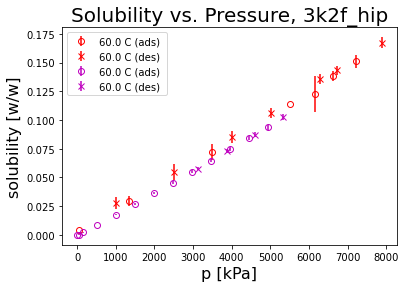

In [23]:
# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s' % (polyol))
df_prev = pd.read_csv(os.path.join(save_folder, '3k2f_60c_lop.csv'))
p_prev = df_prev['p actual [kPa]'].to_numpy(dtype=float)
solubility_prev = df_prev['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_prev = df_prev['solubility error [w/w]'].to_numpy(dtype=float)
ax = plot.plot_errorbars_ads_des(p_prev, solubility_prev, s_solubility_prev, p_prev, 60, ax=ax, color='m')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_repeatability.pdf' % (polyol, T), bbox_inches='tight')

They match (more-or-less)! The remaining discrepancies appear to be of the same scale as those of the drop volume, correcting which is a more laborious task, so I will satisfy myself with the present success and extend the analysis to the specific volume.

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

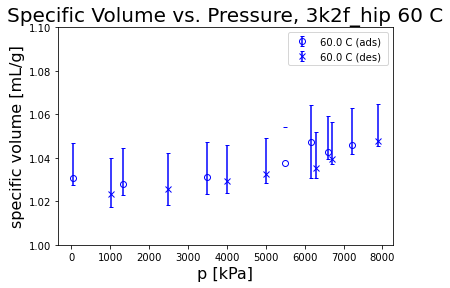

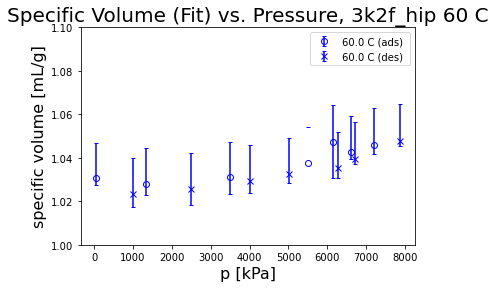

In [24]:
# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)
df['specific volume (fit) [mL/g]'] = spec_vol_fit

# propagate error to estimate uncertainty, distinguishing statistical and systematic
s_spec_vol_stat, s_spec_vol_sys = errprop.error_spec_vol_stat_sys(spec_vol, v_samp, buoyancy, w_gas_act, 
                                                                  v_drop_eq, s_v_drop_eq,  w_poly_arr, 
                                                                  s_frac_rho_co2, w_samp_ref, s_w_samp_ref, rho_samp_ref, 
                                                                  s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                                                  v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
# save separated statistical and systematic errors
s_spec_vol = np.sqrt(s_spec_vol_stat**2 + s_spec_vol_sys**2)
df['specific volume error [mL/g]'] = s_spec_vol
df['specific volume error (stat) [mL/g]'] = s_spec_vol_stat
df['specific volume error (sys) [mL/g]'] = s_spec_vol_sys

# Plot specific volume vs. pressure, stat is bottom error bar, sys is top
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.1])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure for fitted drop volumes
ax = plot.plot_errorbars_ads_des_stat_sys(p_plot, spec_vol_fit, s_spec_vol_stat, s_spec_vol_sys, p_set_arr, T, color='b', 
                                          xlabel='p [kPa]', ylabel='specific volume [mL/g]', 
                                          title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.1])
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_stat_sys_fit_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

The fit specific volume has a systematic bias of a higher value for the adsorption (circles) than the desorption (x's), which makes sense given that the fit for the drop volume fell below the desorption values (underestimating volume) and above the adsorption values (overestimating volume). The closer agreement in specific volume of the non-fit values indicates that the amount of CO2 in the polyol matched the measured drop volume, even if it showed hysteresis.

Again, as a check, we compare these results with those obtained before for this condition at lower pressure.

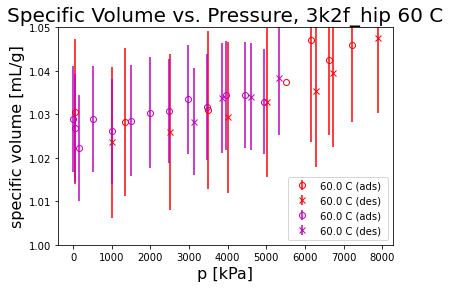

In [25]:
# load previous specific volume data
spec_vol_prev = df_prev['specific volume [mL/g]'].to_numpy(dtype=float)
s_spec_vol_prev = df_prev['specific volume error [mL/g]'].to_numpy(dtype=float)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_prev, spec_vol_prev, s_spec_vol_prev, p_prev, 60, ax=ax, color='m')
ax.set_ylim([1, 1.05])
plt.legend(loc=4)
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dc_comp.pdf' % (polyol, T), bbox_inches='tight')

Thanks to those forgiving error bars, we can conclude that the measurements of specific volume are consistent. Interestingly, by reaching higher pressures, the specific volume noticeably increases, as observed before in Di Caprio et al. *Fl. Ph. Equil.* (2016).

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

In [26]:
t_grav_sec = t_grav*60
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav_sec, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

### Interfacial Tension

At this point, I use the program `auto_density_input_fta32.py` to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

Pressure = 45 kPa.
Rejected 1 outliers.
Interfacial tension = 25.324500 mN/m.
Pressure = 1330 kPa.
Rejected 1 outliers.
Interfacial tension = 23.014000 mN/m.
Pressure = 3500 kPa.
Interfacial tension = 18.645000 mN/m.
Pressure = 5500 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
Interfacial tension data not stored.
Pressure = 6200 kPa.
Rejected 1 outliers.
Interfacial tension = 13.601000 mN/m.
Pressure = 6600 kPa.
Rejected 1 outliers.
Interfacial tension = 12.809500 mN/m.
Pressure = 7200 kPa.
Rejected 1 outliers.
Interfacial tension = 11.789000 mN/m.
Pressure = 7850 kPa.
Rejected 1 outliers.
Interfacial tension = 10.488000 mN/m.
Pressure = 6700 kPa.
Rejected 1 outliers.
Interfacial tension = 12.259000 mN/m.
Pressure = 6300 kPa.
Rejected 1 outliers.
Interfacial tension = 12.909000 mN/m.
Pressure = 5000 kPa.
Rejected 1 outliers.
Interfacial tension = 15.145000 mN/m.
Pressure = 4000 kPa.
Rejected 1 outliers.
Interfacial tension = 17.328500 mN/m.
Pressure

C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


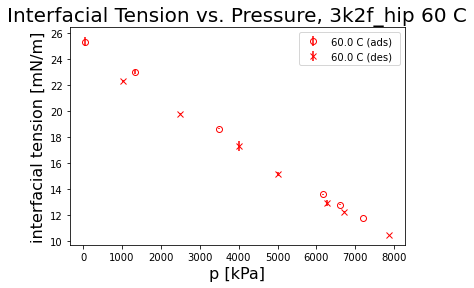

In [27]:
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

### Diffusivity

Because the diffusivity changes with the concentration of CO2 in the polyol, and because the concentration of CO2 in the polyol changes substantially during the course of sorption at a single pressure, we cannot justify the assumption that the diffusivity $D$ is constant throughout the sample or throughout the course of sorption. Instead, we must use models that account for a varying diffusivity, as derived by Crank in *The Mathematics of Diffusion* (1956).

#### Model 1: Use Initial Gradient (eqn. 6 in Pastore et al. 2011; eqn. 7 in Vrentas et al. 1977)

For a constant diffusion coefficient $D$ of a gas diffusing into a sheet of thickness $l$ open to atmosphere on both sides, Crank derives in sect 4.3.2 p. 48 that

\begin{align}
\frac{M_t}{M_{\infty}} &= \frac{4}{\pi^{1/2}}\left(\frac{Dt}{l^2}\right)^{1/2} \\
\end{align}

At the start of diffusion, the diffusion coefficient is constant as diffusion almost exclusively occurs within a thin skin layer along the interface between sample and gas. Somehow (***I don't understand this***), this means that the average diffusion coefficient $\bar{D}$ can be approximated by taking the derivative of the above equation with respect to the square-root of time over the sample thickness squared at the beginning of the experiment ($t = t_0$). Thus,

\begin{align*}
\bar{D} &= \frac{\pi}{16}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t/l^2}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

In this experiment, however, the sample is only open to the atmosphere on one side; on the other, there is no flux, so the boundary condition is $\frac{\partial c}{\partial z} = 0$ (where $c$ is the concentration of the gas and $z$ is the direction of diffusion perpendicular to the surface of the sample), which is mathematically identical to the symmetry condition in the system considered by Crank at the center of the sample. Thus, the present system can be mapped onto that of Crank by simply replacing $l$ (the thickness of the sample exposed to gas on two sides) with $2h_{samp}$ (where $h_{samp}$ is the thickness of the sample in the sorption experiment exposed to gas on one side). Thus,

\begin{align*}
\bar{D} &= \frac{\pi h_{samp}^2}{4}\left[\left.\left(\frac{\mathrm{d}}{\mathrm{d}\left(\sqrt{t}\right)}\right)\left(\frac{M_t}{M_{\infty}}\right)\right|_{t=t_0}\right]^2 \\
\end{align*}

According to the first equation in this cell (10.165 in Crank's textbook), the mass of the sample will initially increase as $t^{1/2}$, so we fit the sample weight at the beginning of sorption to the equation 

\begin{align*}
W_{gas}^{act} &= a \sqrt{t-t_0^{fit}} + b\\
\end{align*}

with fitting parameters $a$, $t_0^{fit}$, and $b$.

$M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ (the dry mass of the polymer under vacuum) is constant, the time derivatives of the gas mass and the total mass are the same. Therefore, at $t = t_0^{fit}$,

\begin{align*}
\left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}W_{gas}^{act}\right|_{t=t_0^{fit}} &= \left.\frac{\mathrm{d}}{\mathrm{d}\sqrt{t}}\left(a \sqrt{t-t_0^{fit}} + b\right)\right|_{t=t_0^{fit}}\\
\left.\frac{\mathrm{d}M_t}{\mathrm{d}\sqrt{t}}\right|_{t=t_0^{fit}} &= a \\
\end{align*}

We can then use the above equation relating the time derivative of the sample mass at the initial time of sorption/desorption $t_0^{fit}$ to the average diffusion constant,

\begin{align*}
\sqrt{M_{\infty}^2\bar{D} \frac{4}{\pi h_{samp}^2}} &= a\\
\bar{D} &= \left(\frac{\pi h_{samp}^2}{4}\right)\left(\frac{a}{M_{\infty}}\right)^2 \\
\end{align*}

As a result, the only remaining parameter to estimate is $M_{\infty}$, the equilibrium mass of the sample. Scaling analysis (***ADD LATER***) shows that at late times the sample mass approaches the equilibrium mass exponentially. Thus, to estimate the equilibrium mass, we fit an exponential curve of the following form to the late-time data points,

\begin{align*}
W_{gas}^{act} &= A e^{Bt} + M_{\infty}\\
\end{align*}

where $A$, $B$, and $M_{\infty}$ are fitting parameters. We then use the fitted value for $M_{\infty}$ and estimate the average diffusion coefficient $\bar{D}$ with the equation above.

#### Fit Initial Time and Mass

Our first approach is to fit both the initial time of the sorption ($t_0$) and the initial mass ($M(t_0)$).

Pressure = 45 kPa.
Rejected 1 outliers.
D_sqrt = 3.02e-07 cm^2/s.
Pressure = 1330 kPa.
Rejected 1 outliers.
D_sqrt = 1.39e-05 cm^2/s.
Pressure = 3500 kPa.
D_sqrt = 1.27e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_sqrt = 1.26e-05 cm^2/s.
Pressure = 6200 kPa.
Rejected 1 outliers.
D_sqrt = 1.70e-03 cm^2/s.
Pressure = 6600 kPa.
Rejected 1 outliers.
D_sqrt = 8.23e-06 cm^2/s.
Pressure = 7200 kPa.
Rejected 1 outliers.
D_sqrt = 1.41e-05 cm^2/s.
Pressure = 7850 kPa.
Rejected 1 outliers.
D_sqrt = 4.06e-03 cm^2/s.

../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b



Pressure = 6700 kPa.
Rejected 1 outliers.
D_sqrt = 3.82e-04 cm^2/s.
Pressure = 6300 kPa.
Rejected 1 outliers.
D_sqrt = 1.95e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 7.91e-06 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 1.85e-02 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.52e-02 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 2.00e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.


../src\dataproc.py:1812: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5) + b
../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


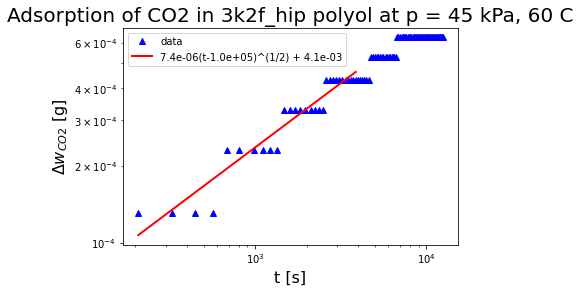

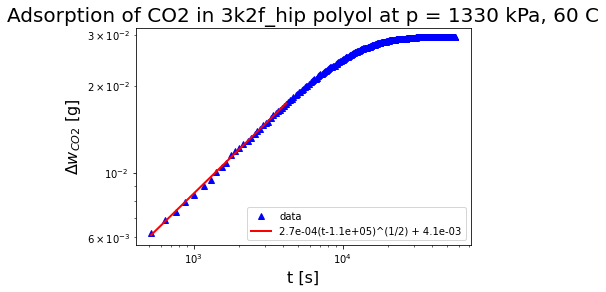

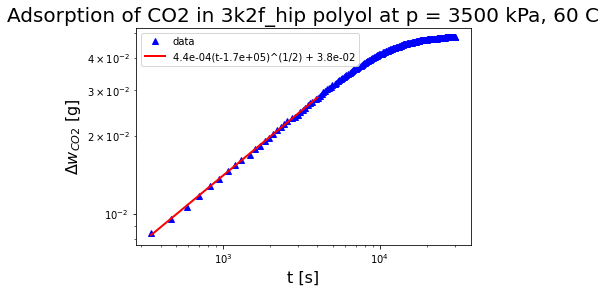

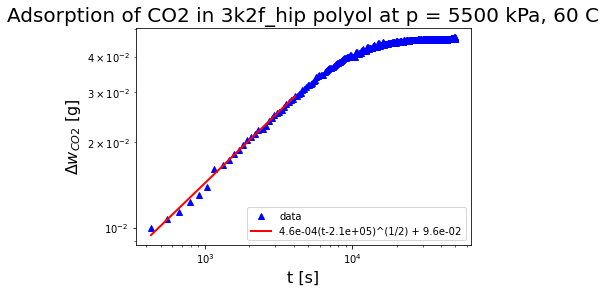

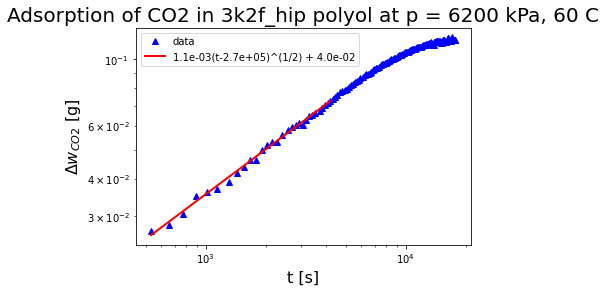

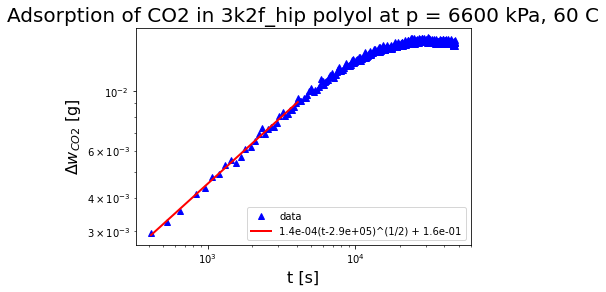

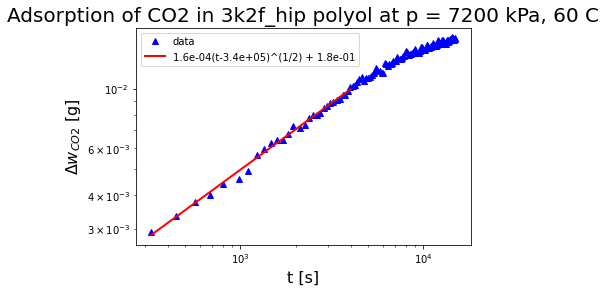

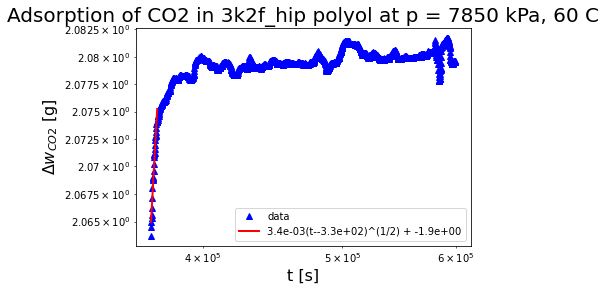

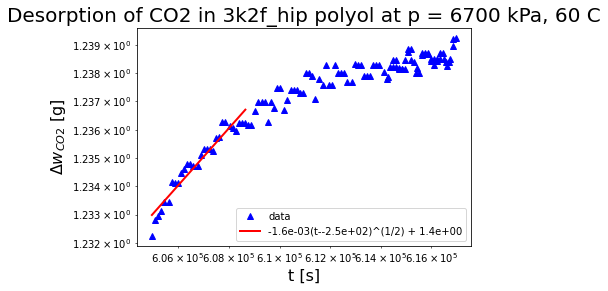

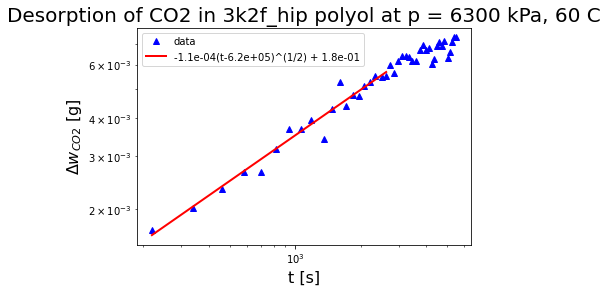

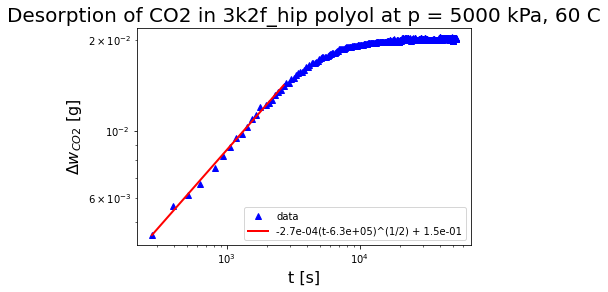

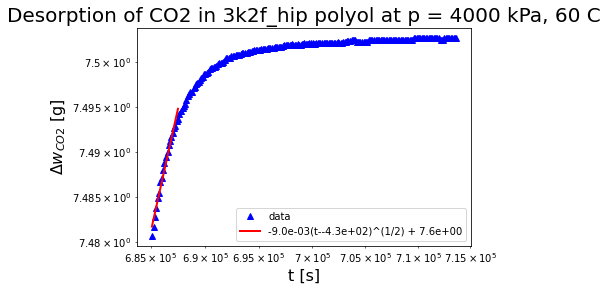

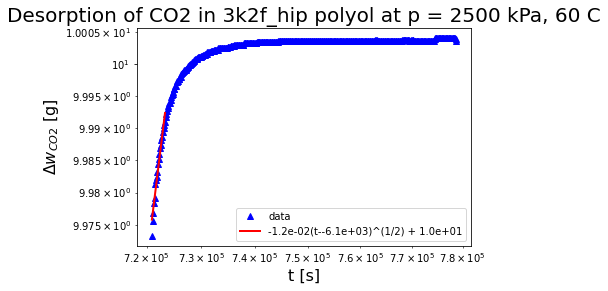

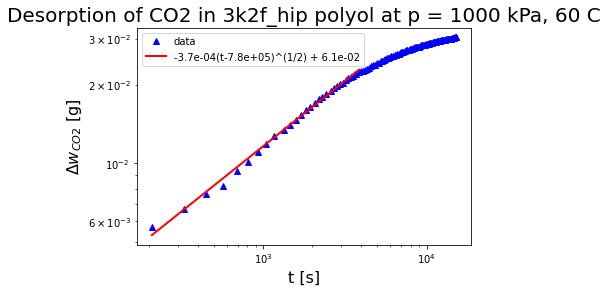

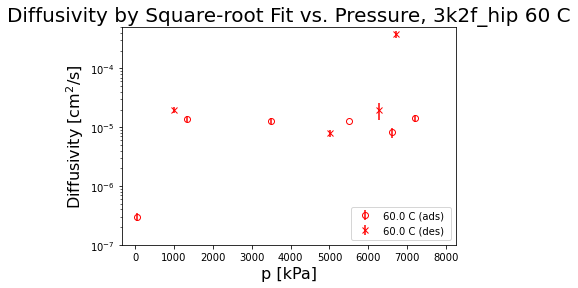

In [28]:
# FOR REFERENCE
# p_set_arr = array([0:45., 1:1330., 2:3500., 3:5500., 4:6200., 5:6600., 6:7200., 7:7850., 8:6700.,
#        9:6300., 10:5000., 11:4000., 12:2500., 13:1000.,  14:500.])
# raise max number of function evaluations for fitting
maxfev = 10000
# number of data points to use for fitting to square root (beginning of curve)
n_pts_sqrt_arr = 30*np.ones([len(p_set_arr)]).astype(int)
n_pts_sqrt_arr[9:-2] = 20
# shift in indices to cut off beginning data points that don't match t^1/2 fit
i_shift = 2*np.ones(len(p_set_arr)).astype(int)
i_shift[0] = 4
i_shift[6] = 5
i_shift[7] = 5
i_shift[8] = 3
i_shift[9] = 10


# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit both initial time t0 and initial mass w0 ***Note: use t_grav_sec so Diffusivity is in cm^2/s
D_sqrt_2fit_arr, M_0_extrap_2fit_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, polyol, 
                                                                                 T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                                 p_thresh_frac, v_ref_he, i_shift, 
                                                                                 maxfev, diam_cruc, fit_t0=True, fit_w0=True)
# Define uncertainties for the first calculation
M_0 = df['M_0 (prev) [g]'].to_numpy(dtype=float)
M_infty = df['M_infty (final) [g]'].to_numpy(dtype=float)
s_M_0 = df['M_0 (prev) std [g]'].to_numpy(dtype=float)
s_M_infty = df['M_infty (final) std [g]'].to_numpy(dtype=float)

# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_2fit_arr = errprop.error_D_sqrt(D_sqrt_2fit_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_2fit_arr, s_D_sqrt_2fit_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 5E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_2fit_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fit Initial Mass

Next we will estimate the diffusivity by fitting the initial mass at the initial time $t_0$ but estimating the initial time $t_0$ as the last time point of the previous pressure step.

Pressure = 45 kPa.
Rejected 1 outliers.
D_sqrt = 4.04e-07 cm^2/s.
Pressure = 1330 kPa.
Rejected 1 outliers.
D_sqrt = 1.78e-05 cm^2/s.
Pressure = 3500 kPa.
D_sqrt = 2.38e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_sqrt = 2.48e-05 cm^2/s.
Pressure = 6200 kPa.
Rejected 1 outliers.
D_sqrt = 1.60e-02 cm^2/s.
Pressure = 6600 kPa.
Rejected 1 outliers.
D_sqrt = 1.31e-05 cm^2/s.
Pressure = 7200 kPa.
Rejected 1 outliers.
D_sqrt = 2.44e-05 cm^2/s.
Pressure = 7850 kPa.
Rejected 1 outliers.
D_sqrt = 1.58e-04 cm^2/s.
Pressure = 6700 kPa.
Rejected 1 outliers.
D_sqrt = 4.52e-06 cm^2/s.
Pressure = 6300 kPa.
Rejected 1 outliers.
D_sqrt = 5.58e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 4.09e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 8.00e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 5.68e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 4.90e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.


../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),


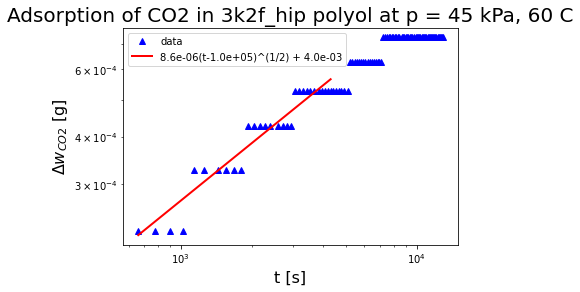

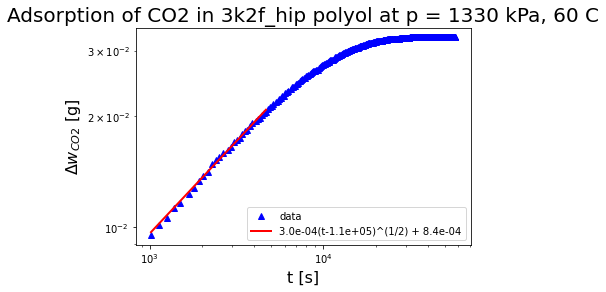

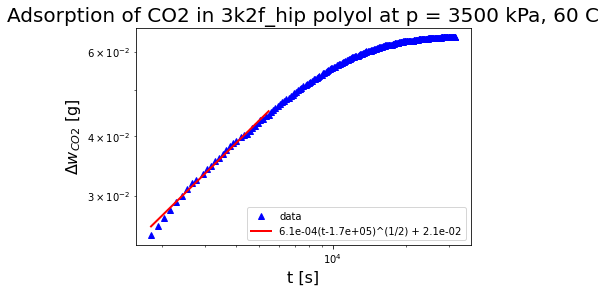

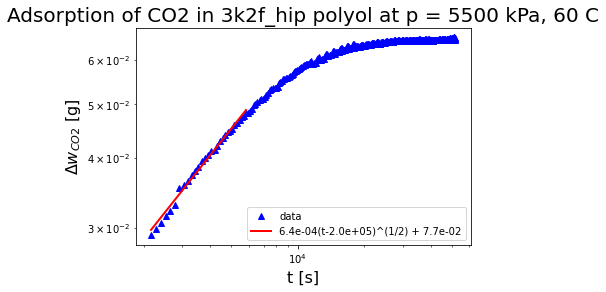

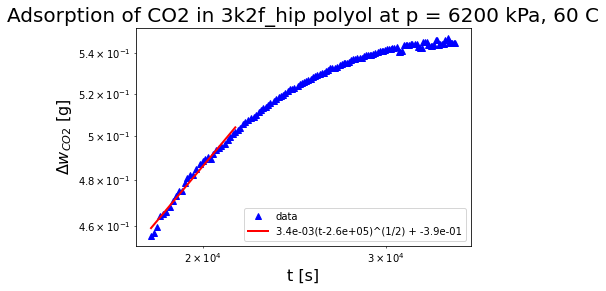

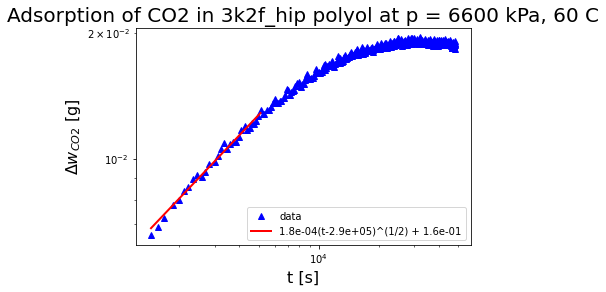

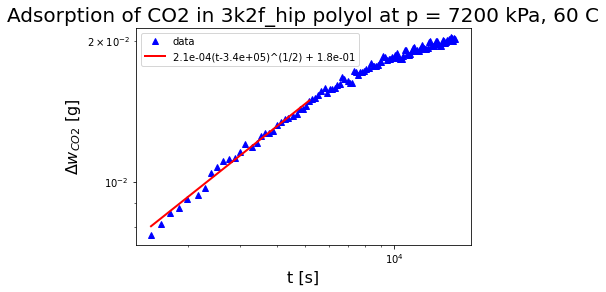

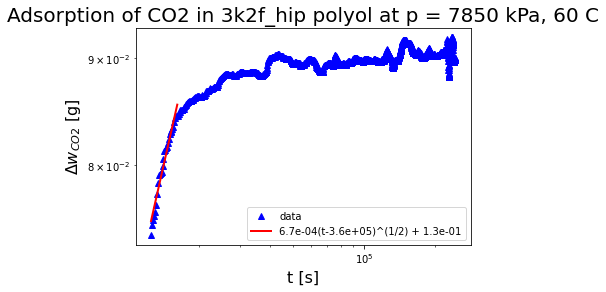

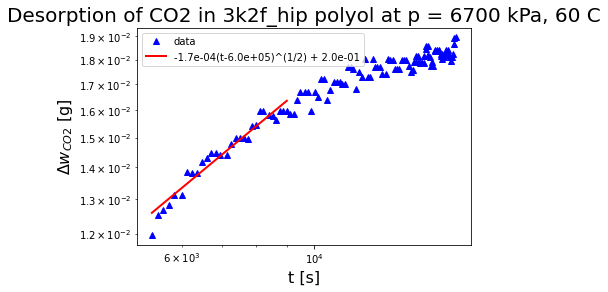

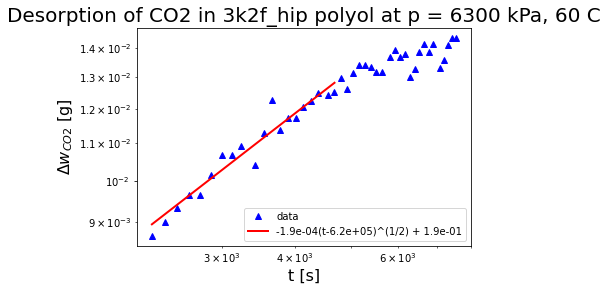

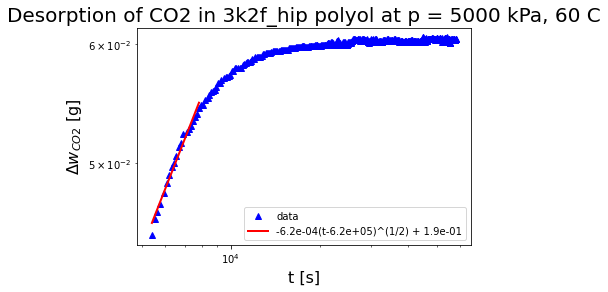

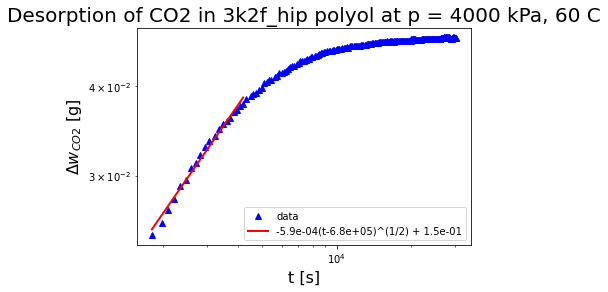

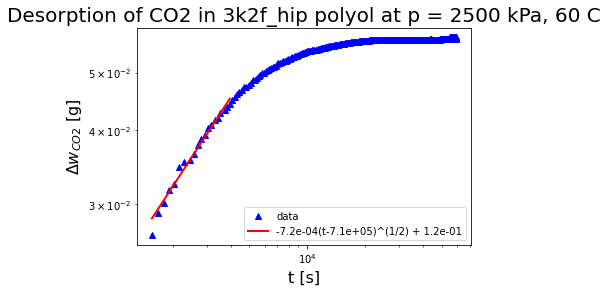

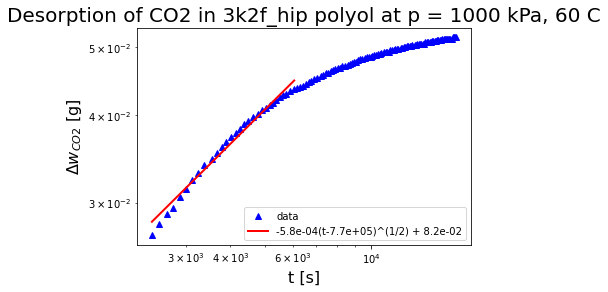

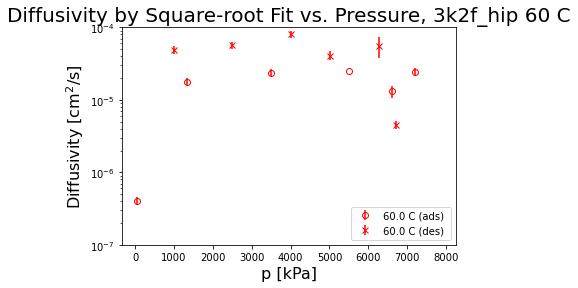

In [29]:
# FOR REFERENCE
# p_set_arr = array([0:45., 1:1330., 2:3500., 3:5500., 4:6200., 5:6600., 6:7200., 7:7850., 8:6700.,
#        9:6300., 10:5000., 11:4000., 12:2500., 13:1000.,  14:500.])

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0 ***Use t_grav_sec
D_sqrt_fitw0_arr, M_0_extrap_fitw0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=True)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitw0_arr = errprop.error_D_sqrt(D_sqrt_fitw0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 1E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitw0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fit Initial Time

In this rendition of the diffusivity calculation, we fit the initial time $t_0$ and estimate the mass at the initial time $M(t_0)$ to be the mass of gas measured at the end of the previous pressure step.

Pressure = 45 kPa.
Rejected 1 outliers.
D_sqrt = 2.98e-11 cm^2/s.
Pressure = 1330 kPa.
Rejected 1 outliers.
D_sqrt = 1.32e-05 cm^2/s.
Pressure = 3500 kPa.
D_sqrt = 1.58e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_sqrt = 1.93e-05 cm^2/s.
Pressure = 6200 kPa.
Rejected 1 outliers.
D_sqrt = 2.02e-09 cm^2/s.


../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\plot.py:216: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)


Pressure = 6600 kPa.
Rejected 1 outliers.
D_sqrt = 1.83e-05 cm^2/s.
Pressure = 7200 kPa.
Rejected 1 outliers.
D_sqrt = 2.44e-05 cm^2/s.
Pressure = 7850 kPa.
Rejected 1 outliers.
D_sqrt = 3.10e-05 cm^2/s.
Pressure = 6700 kPa.
Rejected 1 outliers.
D_sqrt = 1.04e-05 cm^2/s.
Pressure = 6300 kPa.
Rejected 1 outliers.
D_sqrt = 5.12e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.
D_sqrt = 2.62e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 3.30e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 2.84e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 2.44e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.


../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\dataproc.py:1822: RuntimeWarning: invalid value encountered in sqrt
  return a*(t-t0)**(0.5)
../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),
C:\Users\andyl\anaconda3\envs\py36\lib\site

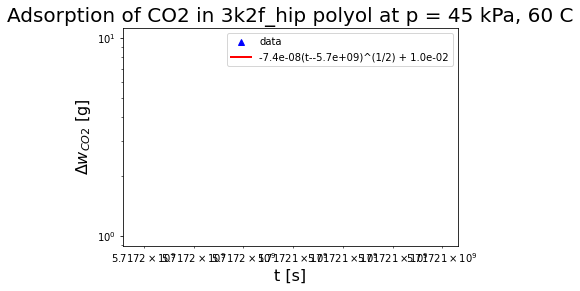

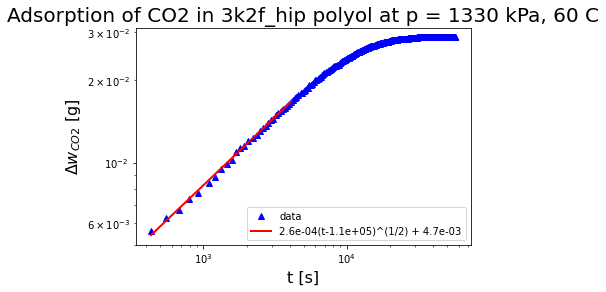

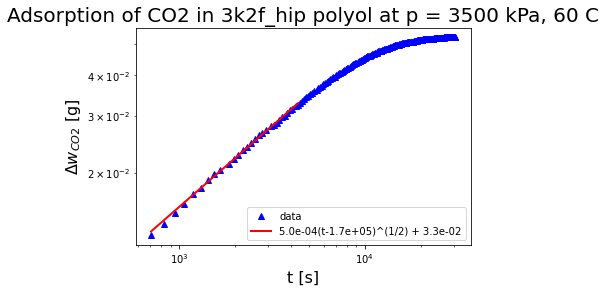

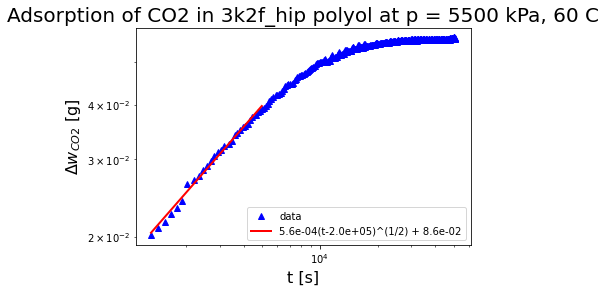

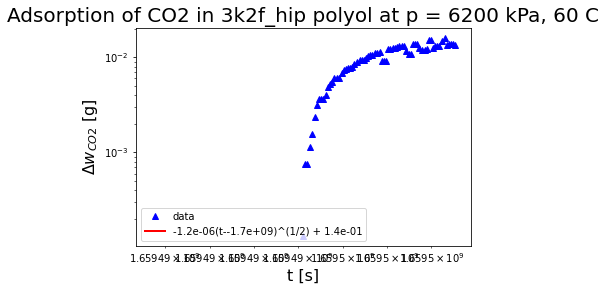

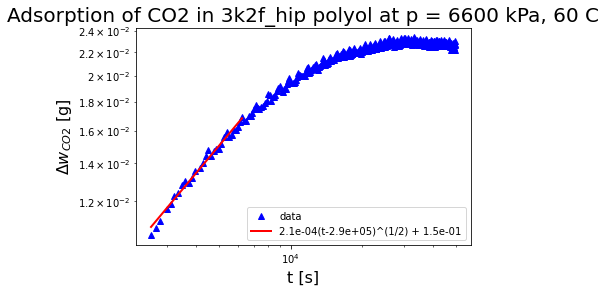

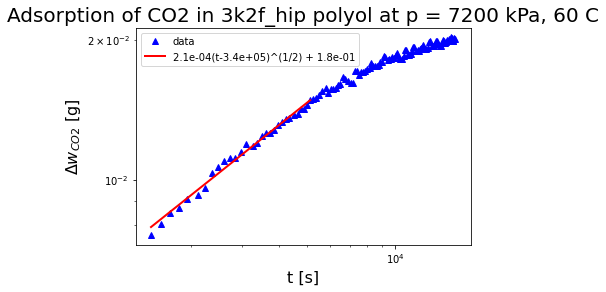

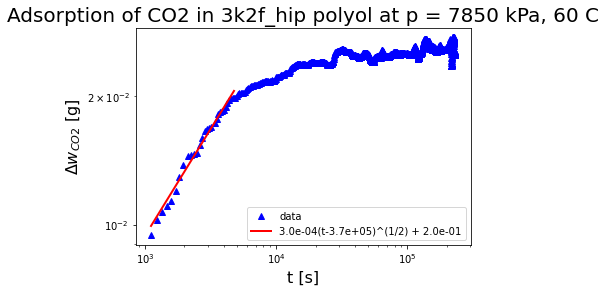

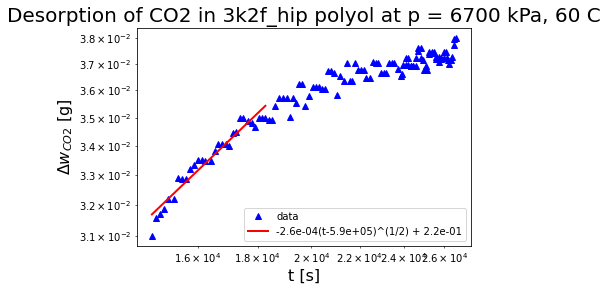

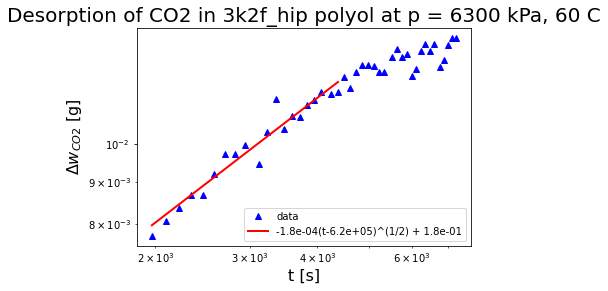

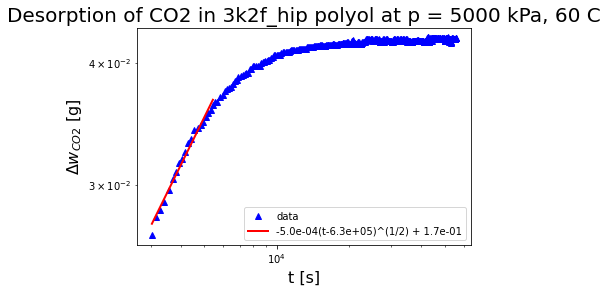

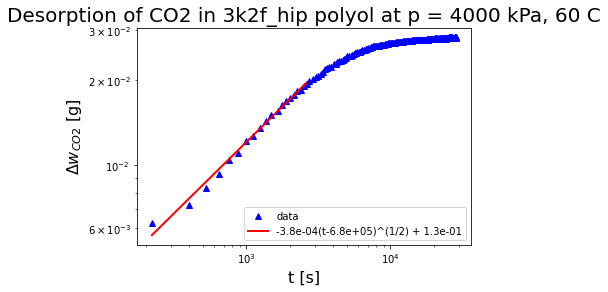

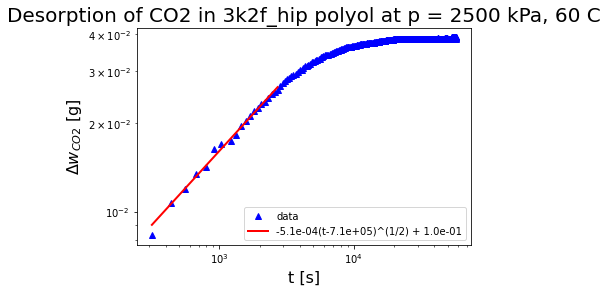

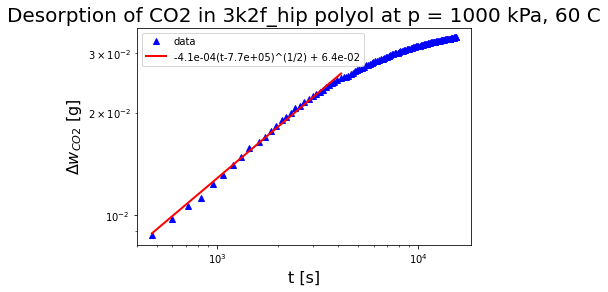

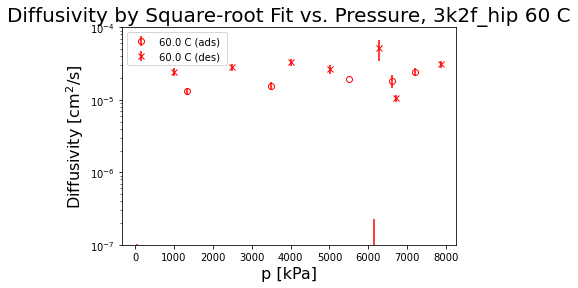

In [30]:
# FOR REFERENCE
# p_set_arr = array([0:45., 1:1330., 2:3500., 3:5500., 4:6200., 5:6600., 6:7200., 7:7850., 8:6700.,
#        9:6300., 10:5000., 11:4000., 12:2500., 13:1000.,  14:500.])

# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# fit initial mass but use last time point of previous experiment as initial time t0 ***use t_grav_sec
D_sqrt_fitt0_arr, M_0_extrap_fitt0_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=True, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fitt0_arr = errprop.error_D_sqrt(D_sqrt_fitt0_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[1E-7, 1E-4],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fitt0_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Fix (Not Fit) the Initial Mass and Initial Time

As a final comparison, we calculate the diffusivity using estimates of the initial time and mass from the experiment, where the initial time is the last time point measured in the previous pressure step and the initial mass of adsorbed gas is that at the end of the previous pressure step.

Pressure = 45 kPa.
Rejected 1 outliers.
D_sqrt = 6.41e-05 cm^2/s.
Pressure = 1330 kPa.
Rejected 1 outliers.
D_sqrt = 1.04e-05 cm^2/s.
Pressure = 3500 kPa.
D_sqrt = 1.09e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_sqrt = 1.52e-05 cm^2/s.
Pressure = 6200 kPa.
Rejected 1 outliers.
D_sqrt = 1.68e-04 cm^2/s.
Pressure = 6600 kPa.
Rejected 1 outliers.
D_sqrt = 2.47e-05 cm^2/s.
Pressure = 7200 kPa.
Rejected 1 outliers.
D_sqrt = 2.41e-05 cm^2/s.
Pressure = 7850 kPa.
Rejected 1 outliers.
D_sqrt = 6.17e-06 cm^2/s.
Pressure = 6700 kPa.
Rejected 1 outliers.
D_sqrt = 2.39e-05 cm^2/s.
Pressure = 6300 kPa.
Rejected 1 outliers.
D_sqrt = 4.66e-05 cm^2/s.
Pressure = 5000 kPa.
Rejected 1 outliers.


../src\plot.py:216: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


D_sqrt = 1.68e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_sqrt = 1.54e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_sqrt = 1.53e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_sqrt = 1.30e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.


../src\errprop.py:61: RuntimeWarning: invalid value encountered in true_divide
  s_D_sqrt = D_sqrt*norm( (2*s_h_samp/h_samp, 2*s_a/a, 2*s_M_0/(M_infty-M_0),
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


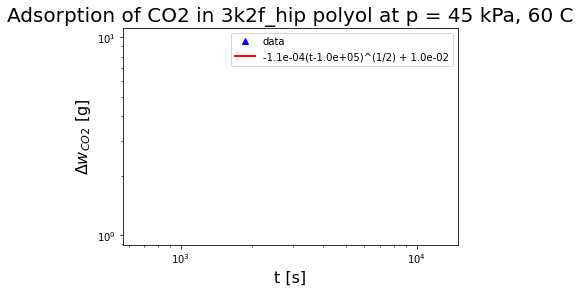

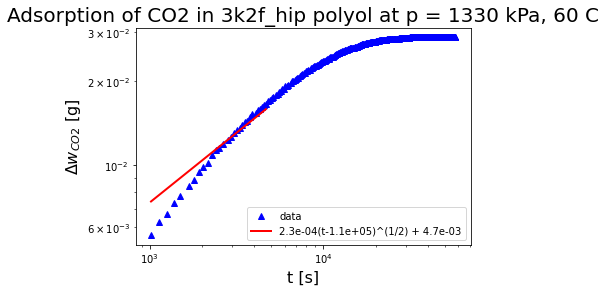

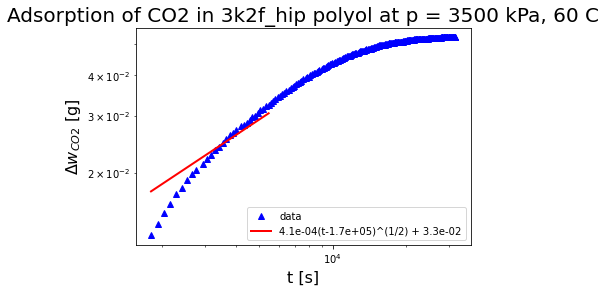

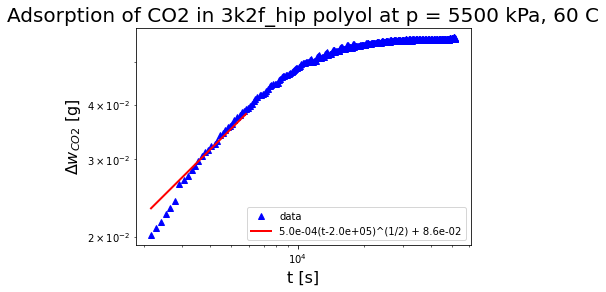

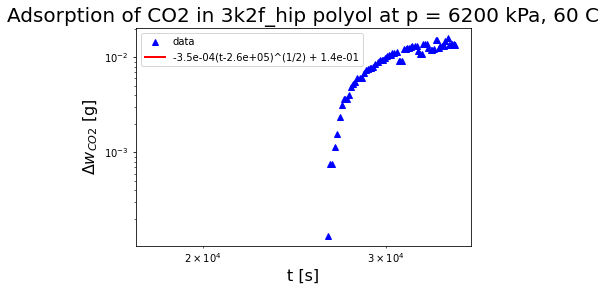

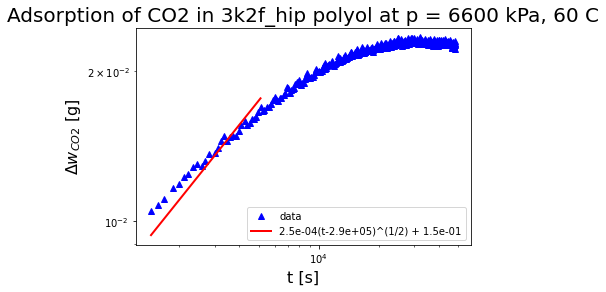

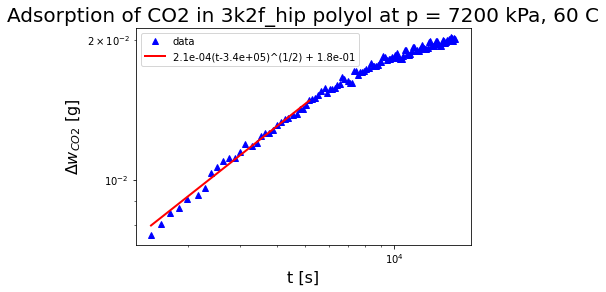

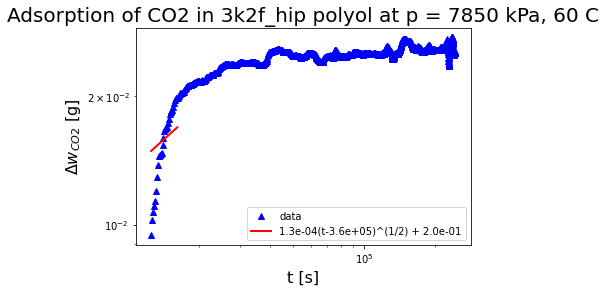

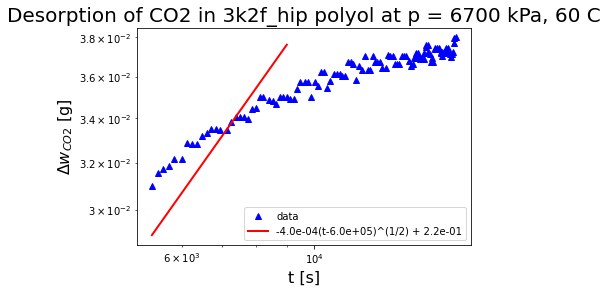

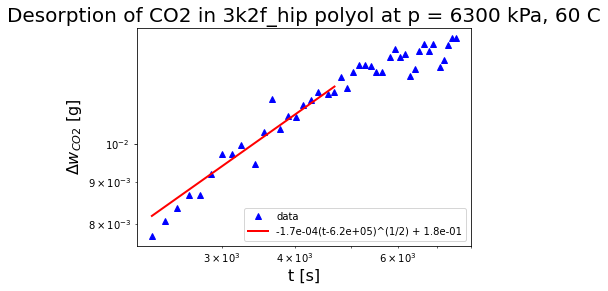

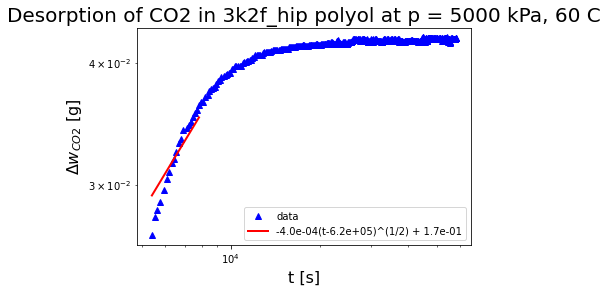

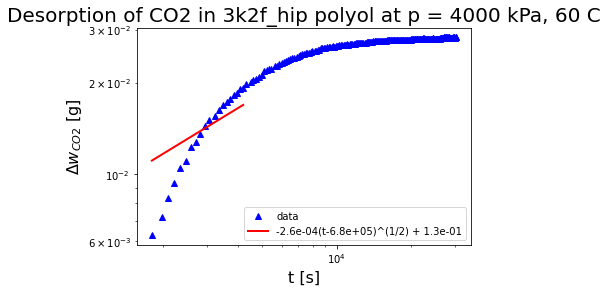

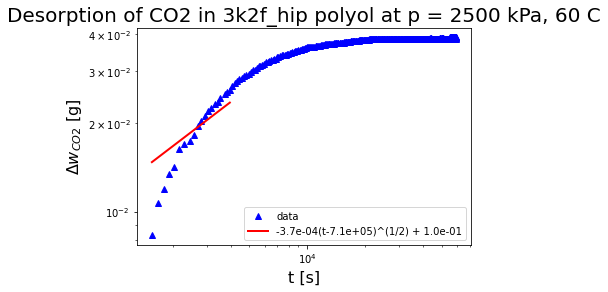

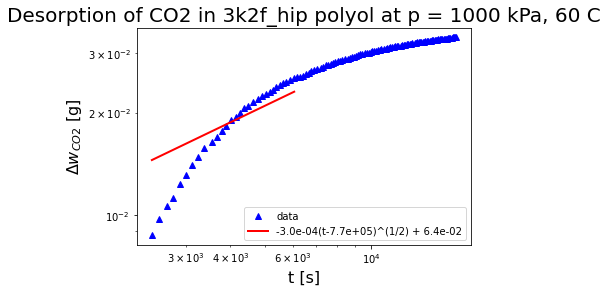

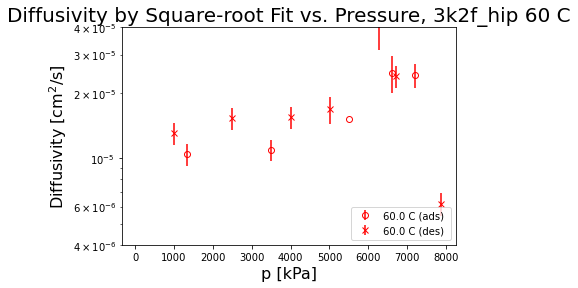

In [31]:
# Compute the diffusivity constant [cm^2/s] and extrapolate initial mass of gas at beginning of pressure step
# use time and mass at end of previous pressure step as estiamtes of initial time and mass ***use t_grav_sec
D_sqrt_fixed_arr, M_0_extrap_fixed_arr, a_arr, s_a_arr = dataproc.diffusivity_sqrt(p_set_arr, n_pts_sqrt_arr, t_grav_sec, 
                                                                                   polyol, T, p_arr, df, bp_arr, br_arr, 
                                                                                   br_eq_0, p_thresh_frac, v_ref_he, 
                                                                                   i_shift, maxfev, diam_cruc, 
                                                                                 fit_t0=False, fit_w0=False)
                                                                                   
# estimate uncertainty in the diffusivity constant [cm^2/s]
s_D_sqrt_fixed_arr = errprop.error_D_sqrt(D_sqrt_fixed_arr, a_arr, s_a_arr, v_samp, v_samp_ref, w_samp_ref, 
                                         s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, v_drop_ref,
                                         s_v_drop_ref, M_0, s_M_0, M_infty, s_M_infty)

# Plot diffusivity vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='r', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', ylog=True, ylim=[4E-6, 4E-5],
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_fixed_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The agreement between the theory and the data is much worse when the theory is not fit to the data, suggesting that our estimation of at least one of the initial mass and the initial time is erroneous.

#### Compare Different Types of Square-root Fits

Below we compare the diffusivities calculated using each of the fits considered above.

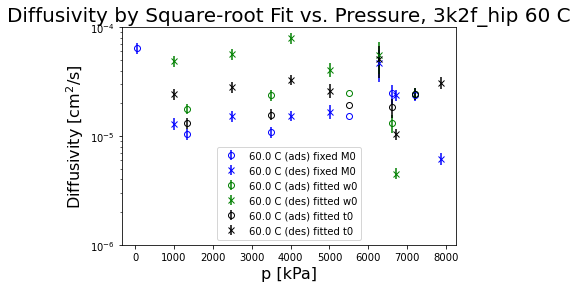

In [32]:
# Plot diffusivity vs. pressure for fixed M_0 and t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fixed_arr, s_D_sqrt_fixed_arr, p_set_arr, T, color='b', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='fixed M0',
                                 title='Diffusivity by Square-root Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# Plot diffusivity vs. pressure for fitted M_0 and fixed t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitw0_arr, s_D_sqrt_fitw0_arr, p_set_arr, T, ax=ax, color='g',
                                label_tag='fitted w0') 
# Plot diffusivity vs. pressure for fixed M_0 and fitted t_0
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, 
                                 color='k', label_tag='fitted t0') 

save_plots=False
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_sqrt_comparison_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

#### Save Results

The fitted t0 values fall in the middle of all the estimated values and are not too widely varying besides the values at high pressures. For some reason the desorption diffusivity is much higher than the adsorption diffusivity for almost every pressure in this experiment, whereas previously this was only the case for the largest desorption steps (highest pressures). For this reason, we will save those values as the results from the square-root fit.

In [33]:
# save results to dataframe
df['diffusivity (sqrt) [cm^2/s]'] = D_sqrt_fitt0_arr
df['diffusivity (sqrt) std [cm^2/s]'] = s_D_sqrt_fitt0_arr
df['M_0 (extrap) [g]'] = M_0_extrap_fitt0_arr

#### Model 2: Exponential Fit (based on equation 10.168 in section 10.6.8 of Crank, 1956)

In the later stages of diffusion, Crank demonstrates that the mass of a sample in an atmosphere of diffusing gas obeys the following equation (equation 10.168 in *The Mathematics of Diffusion*, 1956),

\begin{align*}
\frac{\mathrm{d}}{\mathrm{d}t}\left[\log(M_t - M_{\infty})\right] &= - \frac{D \pi^2}{l^2} \\
\end{align*}

At late enough times, the concentration is close enough to the equilibrium value that the affect of the changing concentration in the system on the diffusion coefficient $D$ is negligible. Therefore, in this model, we assume that $D$ is constant and corresponds to the diffusion coefficient at the equilibrium concentration.

As above, to map this system to the present system where the sample is only exposed to gas on one surface and has a no-flux condition on the other, we replace $l$ with $2 h_{samp}$. We can then integrate the above equation to arrive at the following functional form for the mass of the sample,

\begin{align*}
M_t &= M_{\infty} - (M_{\infty} - M_0) \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\frac{M_{\infty} - M_t}{M_{\infty} - M_0} &= \exp \left[-\frac{D \pi^2}{4 h_{samp}^2} t\right]\\
\end{align*}

where **in this case, as opposed to above for the $t^{1/2}$ fit, $M_0$ is the mass of the sample at the beginning of the exponential behavior (which we define as $t=0$).**

As noted before, $M_t = W_{gas}^{act} + W_{poly}$, and since $W_{poly}$ is constant, it can be "absorbed" in the constant $M_{\infty}$ (so the constant term would represent the equilibrium mass of adsorbed gas rather than of the total sample mass). We can then perform a fit of the mass of adsorbed gas to the following functional form,

\begin{align*}
W_{gas}^{act} &= A \exp \left[B t\right] + C \\
\end{align*}

where $A$, $B$, and $C$ are fitting parameters. Then $C$ is the equilibrium mass of adsorbed gas $W_{gas,\infty}^{act}$ and $B$ can be related to the diffusion constant $D$ by the following equation,

\begin{align*}
D &= -\frac{4 h_{samp}^2}{\pi^2} B\\
\end{align*}

*Note that the change in $h_{samp}$ during the course of a pressure step is negligible relative to the error in the fitted parameter $B$ (at most 2%).*

Pressure = 45 kPa.
Rejected 1 outliers.
D_exp = 2.41e-05 cm^2/s.
Pressure = 1330 kPa.
Rejected 1 outliers.
D_exp = 1.25e-05 cm^2/s.
Pressure = 3500 kPa.
D_exp = 1.59e-05 cm^2/s.
Pressure = 5500 kPa.
Rejected 1 outliers.
D_exp = 2.34e-05 cm^2/s.
Pressure = 6200 kPa.
Rejected 1 outliers.
D_exp = 1.65e-05 cm^2/s.
Pressure = 6600 kPa.
Rejected 1 outliers.
D_exp = 2.00e-05 cm^2/s.
Pressure = 7200 kPa.
Rejected 1 outliers.
D_exp = 4.39e-05 cm^2/s.
Pressure = 7850 kPa.
Rejected 1 outliers.
D_exp = 8.14e-05 cm^2/s.
Pressure = 6700 kPa.
Rejected 1 outliers.
D_exp = 2.52e-05 cm^2/s.
Pressure = 6300 kPa.
Rejected 1 outliers.
D_exp = 7.42e-05 cm^2/s.


../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:487: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
C:\Users\andyl\anaconda3\envs\py36\lib\site-packages\scipy\optimize\minpack.py:487: RuntimeWarning: overflow encountered in multiply
  return transform * (func(xdata, *params) - ydata)
../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
../src\dataproc.py:912: RuntimeWarning: overflow encountered in exp
  return a*np.exp(b*x) + c
../src\errprop.py:38: RuntimeWarning: invalid value encounte

Pressure = 5000 kPa.
Rejected 1 outliers.
D_exp = 3.99e-05 cm^2/s.
Pressure = 4000 kPa.
Rejected 1 outliers.
D_exp = 3.61e-05 cm^2/s.
Pressure = 2500 kPa.
Rejected 1 outliers.
D_exp = 3.33e-05 cm^2/s.
Pressure = 1000 kPa.
Rejected 1 outliers.
D_exp = 2.58e-05 cm^2/s.
Pressure = 500 kPa.
Rejected 1 outliers.


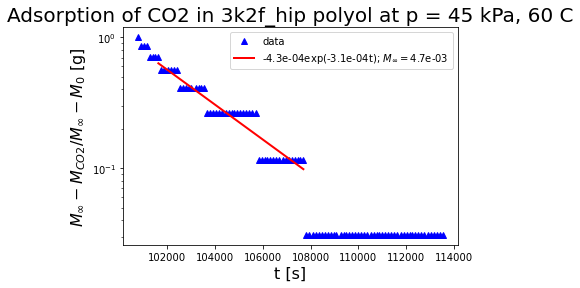

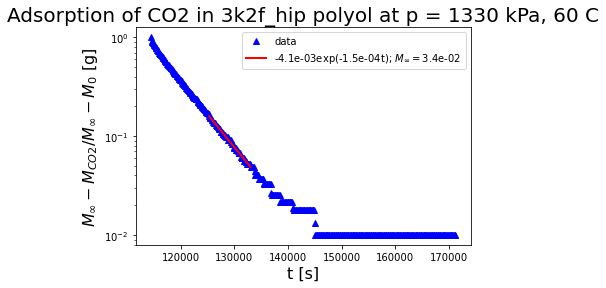

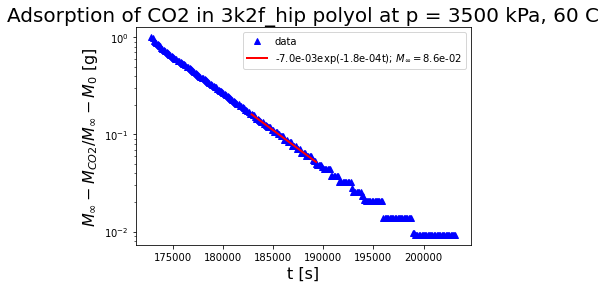

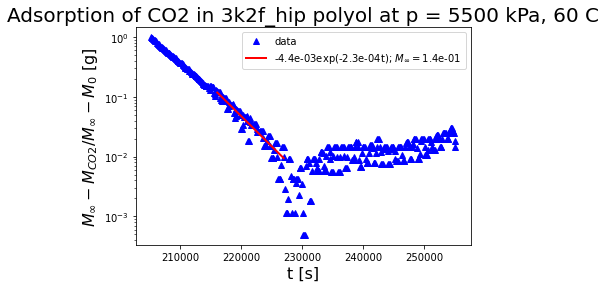

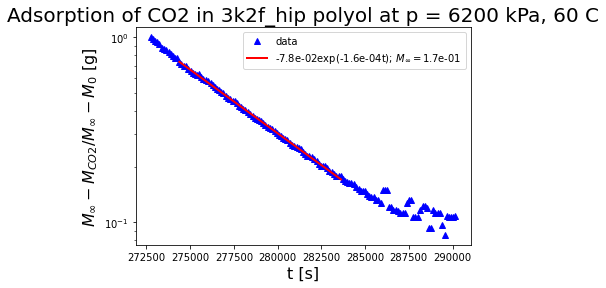

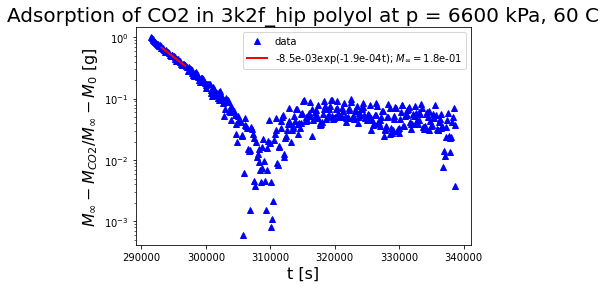

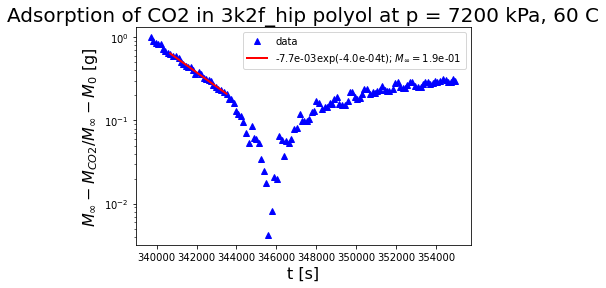

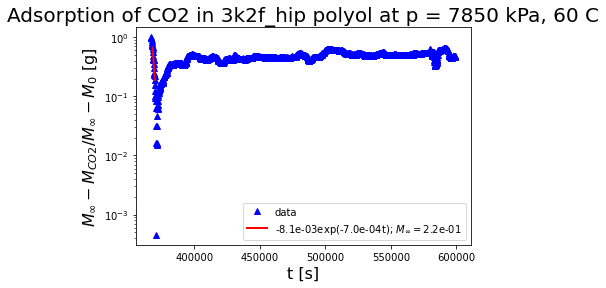

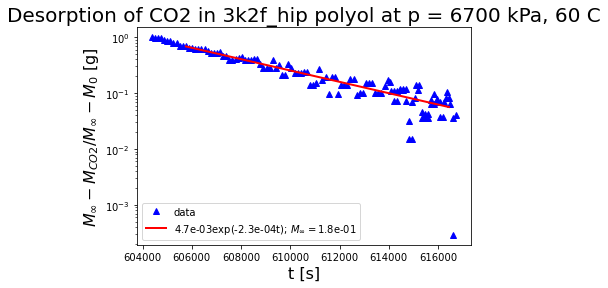

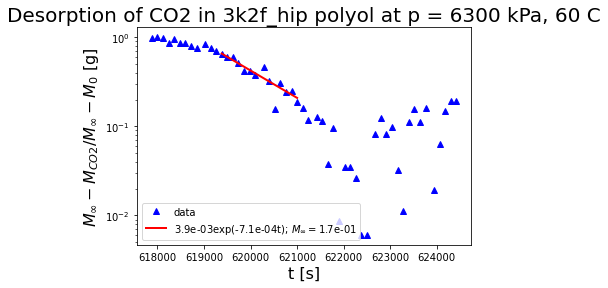

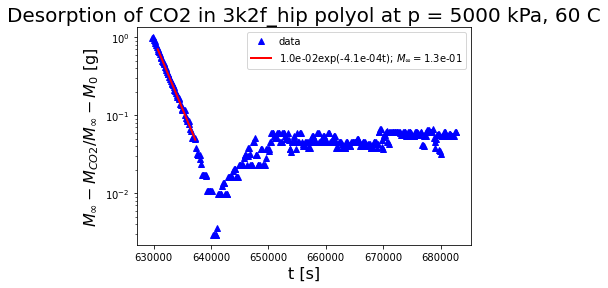

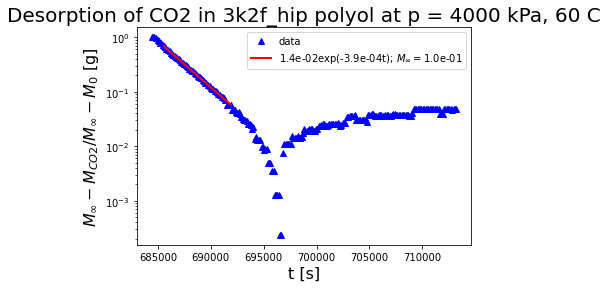

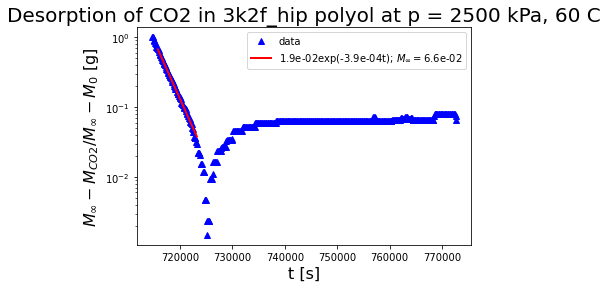

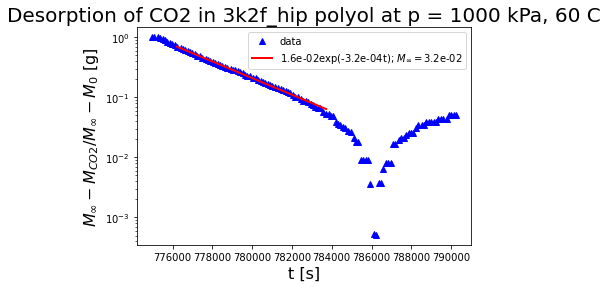

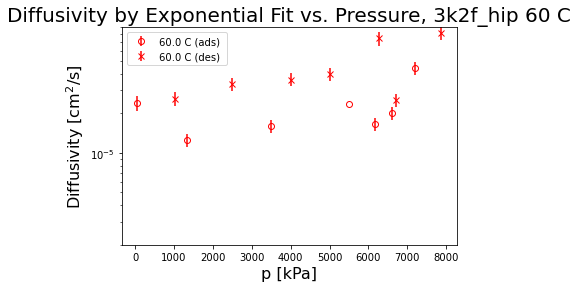

In [34]:
# FOR REFERENCE
# p_set_arr = array([0:45., 1:1330., 2:3500., 3:5500., 4:6200., 5:6600., 6:7200., 7:7850., 8:6700.,
#        9:6300., 10:5000., 11:4000., 12:2500., 13:1000.,  14:500.])
# thresholds for fraction of remaining gas mass to include in fit
thresh0_arr = 0.15*np.ones([len(p_set_arr)])
thresh1_arr = 0.04*np.ones([len(p_set_arr)])
# individual thresholds
thresh0_arr[0] = 0.7
thresh1_arr[0] = 0.1
thresh0_arr[4] = 0.7 # 6200
thresh1_arr[4] = 0.1 # 6200
thresh0_arr[5] = 0.7 # 6600
thresh1_arr[5] = 0.4 # 6600
thresh0_arr[6] = 0.7 # 7200
thresh1_arr[6] = 0.4 # 7200
thresh0_arr[7] = 0.8 # 7850 
thresh1_arr[7] = 0.5 # 7850
thresh0_arr[8] = 0.7 # 6700
thresh1_arr[8] = 0.1 # 6700
thresh0_arr[9] = 0.7 # 6300
thresh1_arr[9] = 0.3 # 6300
thresh0_arr[10:] = 0.7 # 5000 on
thresh1_arr[10:] = 0.1 # 5000 on

# list of terms used for computing errors in results
err_list = [v_samp, v_samp_ref, w_samp_ref, s_w_samp_ref, rho_samp_ref, s_rho_samp_ref, v_drop_eq, s_v_drop_eq, 
            v_drop_ref, s_v_drop_ref]

# compute diffusivity [cm^2/s] with exponential fit, uncertainty [cm^2/s], mass at infinite time [g], and time constant [s]
D_exp_arr, s_D_exp_arr, M_infty_arr, tau_arr = dataproc.diffusivity_exp(p_set_arr, thresh0_arr, thresh1_arr, t_grav_sec, 
                                                                        polyol, T, p_arr, df, bp_arr, br_arr, br_eq_0, 
                                                                        p_thresh_frac, v_ref_he, diam_cruc, err_list)

# record diffusivity and uncertainty calculated using the exponential fit in the data frame [cm^2/s]
df['diffusivity (exp) [cm^2/s]'] = D_exp_arr
df['diffusivity (exp) std [cm^2/s]'] = s_D_exp_arr
# record mass extrapolated at time goes to infinity [g]
df['M_infty (extrap) [g]'] = M_infty_arr
# record fitted exponential time constant [s]
df['diffusion time constant [s]'] = tau_arr

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', 
                                 title='Diffusivity by Exponential Fit vs. Pressure, %s %d C' % (polyol, T))
ax.set_yscale('log')
ax.set_ylim([2E-6,9E-5])
# save figure
if save_plots:
    plt.savefig(save_folder + 'diff_exp_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

The fits get very poor at low values of the normalized mass (nearing the asymptotic mass). I believe that this is a result of obtaining the values of the balance reading from the plots produced by the Belsorp software using Datathief, which may introduce some noise or systematic shifts by choosing to trace on the top or bottom part of the plot line.

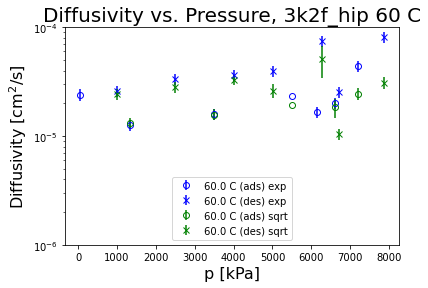

In [35]:
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, D_exp_arr, s_D_exp_arr, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel=r'Diffusivity [cm$^2$/s]', label_tag='exp',
                                 title='Diffusivity vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_plot, D_sqrt_fitt0_arr, s_D_sqrt_fitt0_arr, p_set_arr, T, ax=ax, color='g', 
                                 xlabel='p [kPa]', ylabel=r'Diffusivity [cm$^2$/s]', label_tag='sqrt')
ax.set_yscale('log')
ax.set_ylim([1E-6, 1E-4])

# save figure
save_plots = True
if save_plots:
    plt.savefig(save_folder + 'diff_exp_sqrt_%s_%dC.pdf' % (polyol, T), bbox_inches='tight')

There is close agreement between the exponential and square-rooting fitting methods for all but the very low pressures and the highest pressure, suggesting that these are reliable estimates of the diffusivity.